<a href="https://colab.research.google.com/github/cincysam6/Field_Control_Model/blob/main/Field_Control_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Magic
# %matplotlib inline

# Utility Libraries
from datetime import datetime
import pytz
from google.colab import files
from scipy.ndimage import gaussian_filter

# HTML
from IPython.display import HTML

# Computation Libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import multivariate_normal, gamma
from scipy.spatial.distance import pdist, squareform

# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.patches import Rectangle, Arrow

from __future__ import annotations

from dataclasses import dataclass
from typing import Iterable, Optional, Tuple

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, gamma


# Graph Libraries
import networkx as nx

from __future__ import annotations

from typing import Any, Dict, List, Optional, Sequence, Tuple, Union
import math



# Start by importing PBP data

I Import a single play to test this out. Here we have play_id 2617 and gameId 2022092504 from the 2025 Big Data Bowl Competition.

In [2]:
df = pd.read_csv('/content/drive/MyDrive/BDB_Data/pres_example_play.csv')
df.head()

,Unnamed: 0,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,team,...,is_off,position,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,y_norm,x_norm,std_x,std_y,player_tags
0,1,2022092504,2617,38632.0,Kirk Cousins,1,BEFORE_SNAP,2022-09-25 19:03:06.2,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.87,1.84,off
1,2,2022092504,2617,38632.0,Kirk Cousins,2,BEFORE_SNAP,2022-09-25 19:03:06.3,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
2,3,2022092504,2617,38632.0,Kirk Cousins,3,BEFORE_SNAP,2022-09-25 19:03:06.4,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
3,4,2022092504,2617,38632.0,Kirk Cousins,4,BEFORE_SNAP,2022-09-25 19:03:06.5,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.85,1.82,off
4,5,2022092504,2617,38632.0,Kirk Cousins,5,BEFORE_SNAP,2022-09-25 19:03:06.6,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.83,1.81,off


In [3]:
#df = pd.read_parquet('/content/drive/MyDrive/BDB_Data/motion_df_for_pitch_control.parquet')


# Filter the DataFrame
filtered_df = df[(df['gameId'] == 2022092504) & (df['playId'] == 2617)]

# Display the filtered DataFrame
print(filtered_df.head())


   Unnamed: 0      gameId  playId    nflId   displayName  frameId  \
0           1  2022092504    2617  38632.0  Kirk Cousins        1   
1           2  2022092504    2617  38632.0  Kirk Cousins        2   
2           3  2022092504    2617  38632.0  Kirk Cousins        3   
3           4  2022092504    2617  38632.0  Kirk Cousins        4   
4           5  2022092504    2617  38632.0  Kirk Cousins        5   

     frameType                   time  jerseyNumber team  ... is_off  \
0  BEFORE_SNAP  2022-09-25 19:03:06.2           8.0  MIN  ...    1.0   
1  BEFORE_SNAP  2022-09-25 19:03:06.3           8.0  MIN  ...    1.0   
2  BEFORE_SNAP  2022-09-25 19:03:06.4           8.0  MIN  ...    1.0   
3  BEFORE_SNAP  2022-09-25 19:03:06.5           8.0  MIN  ...    1.0   
4  BEFORE_SNAP  2022-09-25 19:03:06.6           8.0  MIN  ...    1.0   

   position  pff_defensiveCoverageAssignment  \
0        QB                              NaN   
1        QB                              NaN   
2       

# Isolate the data to a single player

For testing purposes we will use Adam Thielen to see how our decisions around paramters for our field control model impact the density it produces

In [4]:
### Selecting a single player ID to test this out
one_player = [40488.0]

In [5]:
single_player = filtered_df[filtered_df['nflId'].isin(one_player)]

In [6]:

# Function to compute distance from the football for a given frame
def compute_distances_by_frame(frame_data):
    # Isolate the football's position within the frame
    football_row = frame_data[frame_data['displayName'] == 'football']
    if football_row.empty:
        # If no football is present in the frame, return NaN for distances
        frame_data['dist_from_football'] = np.nan
    else:
        football_x = football_row['x'].values[0]
        football_y = football_row['y'].values[0]
        # Compute the distance for all players in the frame
        frame_data['dist_from_football'] = np.sqrt((frame_data['x'] - football_x) ** 2 +
                                                   (frame_data['y'] - football_y) ** 2)
    return frame_data

# Apply the function for each frameId group
df = df.groupby('frameId').apply(compute_distances_by_frame)

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Verify results
print(df[['frameId', 'displayName', 'dist_from_football']])

      frameId         displayName  dist_from_football
0           1        Kirk Cousins            6.201815
1           1        Adam Thielen            6.730499
2           1      Charles Harris            2.227667
3           1       Alex Anzalone            3.314362
4           1        Johnny Mundt            5.450616
...       ...                 ...                 ...
4135      180  Christian Darrisaw           20.413538
4136      180        Alim McNeill           24.373954
4137      180           Ed Ingram           22.974850
4138      180   Malcolm Rodriguez            8.990200
4139      180            football            0.000000

[4140 rows x 3 columns]


/tmp/ipython-input-525440378.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('frameId').apply(compute_distances_by_frame)


In [7]:
single_player[['frameId','dir','s','o']]

,frameId,dir,s,o
180,1,21.41,0.55,71.17
181,2,18.70,0.92,68.65
182,3,17.54,1.31,66.92
183,4,16.72,1.67,67.89
184,5,16.06,1.92,66.38
...,...,...,...,...
355,176,76.64,4.65,53.16
356,177,75.23,4.37,53.16
357,178,70.16,4.00,52.15
358,179,61.73,3.70,48.25


# Check players direction and orientation

Before we start our field control functions it is useful to take a look at some of the x,y data and ensure our player's orientation and direction make sense. This will also act as a base for use to check our results against

In [8]:

from typing import Iterable, Optional, Tuple, Sequence

def plot_dir_orientation_small_multiples(
    df: pd.DataFrame,
    *,
    frame_ids: Optional[Sequence[int]] = None,
    base_frame: Optional[int] = None,
    offsets: Sequence[int] = (0, 29, 59, 89, 119, 149, 179),
    # columns
    frame_col: str = "frameId",
    x_col: str = "x",
    y_col: str = "y",
    dir_col: str = "dir",   # 0° = north/up, clockwise increasing
    ori_col: str = "o",     # same convention as dir (per your data)
    speed_col: str = "s",   # yards/s (optional, only for arrow scaling)
    # field + styling
    field_x_max: float = 120.0,
    field_y_max: float = 53.3,
    cols: int = 4,
    arrow_len: float = 6.0,         # base arrow length (yards)
    scale_with_speed: bool = True,  # modestly scale arrow by speed
    dir_color: str = "tab:blue",
    ori_color: str = "tab:orange",
    grid_alpha: float = 0.15,
    title_prefix: str = "Dir vs Orientation",
    show: bool = True,
) -> Tuple[plt.Figure, np.ndarray]:
    """
    Small-multiples diagnostic for a *single player's* direction vs orientation.

    Panels show: player's (x, y) and two arrows:
      - dir_col (direction): colored `dir_color`
      - ori_col (orientation): colored `ori_color`

    Angle convention (matches your tracking):
      - 0° = due north (up, +Y)
      - degrees increase clockwise to 360°
      - conversion to matplotlib radians: theta = radians(90 - deg)

    Args
    ----
    df : DataFrame with at least [frame_col, x_col, y_col, dir_col, ori_col].
          Should be a single player's rows (or pre-filtered to one player).
    frame_ids : explicit list of frame IDs to plot (takes precedence if provided).
    base_frame : if provided (and frame_ids is None), build frames as base_frame + offsets.
    offsets : relative offsets from base_frame when frame_ids is None.
    frame_col, x_col, y_col, dir_col, ori_col, speed_col : column names.
    field_x_max, field_y_max : field dimensions in yards.
    cols : number of columns in the subplot grid.
    arrow_len : base arrow length in yards.
    scale_with_speed : if True, multiply arrow length by (0.75 + min(s, 11.3)/22.6).
    dir_color, ori_color : colors for the two arrows.
    grid_alpha : grid transparency.
    title_prefix : figure title prefix.
    show : call plt.show() before returning.

    Returns
    -------
    (fig, axes) : Matplotlib figure and flat array of Axes.
    """
    if frame_ids is None:
        if base_frame is None:
            base_frame = int(df[frame_col].min())
        frame_ids = [base_frame + off for off in offsets]

    frames_available = set(df[frame_col].unique())
    frames_to_plot = [f for f in frame_ids if f in frames_available]
    missing = [f for f in frame_ids if f not in frames_available]
    if not frames_to_plot:
        raise ValueError("None of the requested frames are present in the DataFrame.")
    if missing:
        print(f"Note: skipping missing frames: {missing}")

    def to_theta(deg: float) -> float:
        # Your convention -> matplotlib (0 rad = +X, CCW)
        return np.deg2rad(90.0 - deg)

    n = len(frames_to_plot)
    rows = int(np.ceil(n / cols))
    aspect = field_y_max / field_x_max
    fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 4.5 * rows * aspect))
    axes = np.array(axes).reshape(-1)

    for ax, fid in zip(axes, frames_to_plot):
        row = df.loc[df[frame_col] == fid]
        if row.empty:
            ax.axis("off")
            continue
        r = row.iloc[0]

        x0, y0 = float(r[x_col]), float(r[y_col])
        dir_deg = float(r[dir_col]) if pd.notna(r[dir_col]) else None
        ori_deg = float(r[ori_col]) if pd.notna(r[ori_col]) else None
        spd = float(r[speed_col]) if speed_col in r and pd.notna(r[speed_col]) else 0.0

        # modest speed scaling (keeps arrows readable)
        scale = (0.75 + min(max(spd, 0.0), 11.3) / 22.6) if scale_with_speed else 1.0
        L = arrow_len * scale

        # field + yard lines
        ax.set_xlim(0, field_x_max)
        ax.set_ylim(0, field_y_max)
        for x in range(10, int(field_x_max), 10):
            ax.axvline(x, color="k", lw=1, alpha=0.06)
        ax.scatter(x0, y0, s=60, c="k", zorder=5)

        # draw direction arrow
        if dir_deg is not None:
            th = to_theta(dir_deg)
            ax.arrow(x0, y0, L * np.cos(th), L * np.sin(th),
                     head_width=1.2, head_length=2.0, fc=dir_color, ec=dir_color, lw=1.5, zorder=6)

        # draw orientation arrow
        if ori_deg is not None:
            th_o = to_theta(ori_deg)
            ax.arrow(x0, y0, L * np.cos(th_o), L * np.sin(th_o),
                     head_width=1.2, head_length=2.0, fc=ori_color, ec=ori_color, lw=1.5, alpha=0.8, zorder=6)

        # panel title with exact values
        t_dir = f"{dir_deg:.2f}°" if dir_deg is not None else "NA"
        t_ori = f"{ori_deg:.2f}°" if ori_deg is not None else "NA"
        ax.set_title(f"Frame {fid}  |  dir={t_dir}  |  o={t_ori}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(alpha=grid_alpha)

    # turn off any extra axes
    for ax in axes[n:]:
        ax.axis("off")

    fig.suptitle(f"{title_prefix}: direction (blue) vs orientation (orange) for single player on single play ", fontsize=14)
    fig.tight_layout(rect=[0, 0.02, 1, 0.95])

    if show:
        plt.show()
    return fig, axes


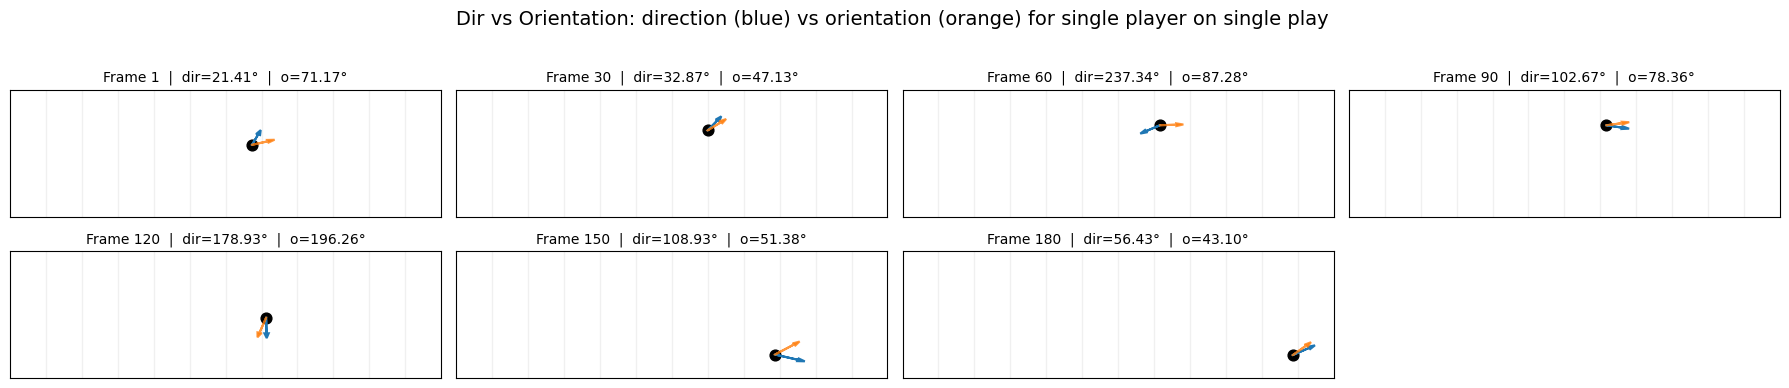

(<Figure size 1800x399.75 with 8 Axes>,
 array([<Axes: title={'center': 'Frame 1  |  dir=21.41°  |  o=71.17°'}>,
        <Axes: title={'center': 'Frame 30  |  dir=32.87°  |  o=47.13°'}>,
        <Axes: title={'center': 'Frame 60  |  dir=237.34°  |  o=87.28°'}>,
        <Axes: title={'center': 'Frame 90  |  dir=102.67°  |  o=78.36°'}>,
        <Axes: title={'center': 'Frame 120  |  dir=178.93°  |  o=196.26°'}>,
        <Axes: title={'center': 'Frame 150  |  dir=108.93°  |  o=51.38°'}>,
        <Axes: title={'center': 'Frame 180  |  dir=56.43°  |  o=43.10°'}>,
        <Axes: >], dtype=object))

In [9]:
plot_dir_orientation_small_multiples(single_player)

In [10]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Iterable, Optional, Tuple, Sequence

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, gamma


# ---------------------------------------------------------------------------
# Grid: small immutable container to carry X/Y meshgrids together
# ---------------------------------------------------------------------------

@dataclass(frozen=True)
class Grid:
    """
    Immutable container for the field grid used by the model.

    Attributes
    ----------
    X : np.ndarray
        2D array of x-coordinates, shape (ny, nx).
    Y : np.ndarray
        2D array of y-coordinates, shape (ny, nx).

    Notes
    -----
    - We keep X and Y together so every density is evaluated on a
      consistent coordinate system (no shape mismatches during plotting).
    """
    X: np.ndarray  # shape (ny, nx)
    Y: np.ndarray  # shape (ny, nx)

    @property
    def x_vals(self) -> np.ndarray:
        """1D x coordinate axis (length nx)."""
        return self.X[0, :]

    @property
    def y_vals(self) -> np.ndarray:
        """1D y coordinate axis (length ny)."""
        return self.Y[:, 0]


# ---------------------------------------------------------------------------
# PlayerInfluenceModel
#   Gaussian + Gamma mixture on a football field grid
# ---------------------------------------------------------------------------

class PlayerInfluenceModel:
    """
    Player influence density model (Gaussian + Gamma mixture) with tunable controls.

    Angle conventions
    -----------------
    Tracking data:
      - 0° = due north (up, +Y)
      - degrees increase clockwise (to 360°)

    Math/Matplotlib:
      - 0 rad = +X, CCW is positive
      - canonical conversion used everywhere:
            theta = radians(90 - deg)

    High‑level intuition
    --------------------
    - The **Gaussian** term captures local, elliptical influence around the player,
      elongated along their heading and modestly scaled by speed.
    - The **Gamma** term captures **forward reach**: mass distributed *ahead*
      of the player along the heading, tapered by a forward cap and angular cone.
    - A **speed‑dependent weight** mixes the two: more Gaussian at low speed,
      more Gamma as speed rises.

    Parameters (hyperparameters)
    ----------------------------
    grid_x_res, grid_y_res : int
        Resolution of the evaluation grid along X and Y.
        Higher = smoother but more compute/memory.

    field_x_max, field_y_max : float
        Field limits in yards (default NFL: 120 × 53.3).

    orientation_bias_deg : float
        Global bias (in degrees) added *only if* `apply_bias=True`
        in `theta_from_tracking`. Keep **0.0** to match tracking as-is.

    gaussian_scale_factor : float
        Scales the Gaussian covariance ellipses (both axes). Larger spreads
        out local influence; smaller concentrates it.

    alpha_gamma : float
        Shape parameter (k) for the **Gamma** pdf along the forward axis.
        Higher α → peakier, lower α → flatter.

    beta_min, beta_max : float
        Bounds for the dynamic rate (β) used by the Gamma component. We ramp
        β with speed to adjust reach in a controlled range.

    gamma_midpoint : float
        Speed (yd/s) at which the **β ramp** is centered (used in a simple
        linear clip). Larger midpoint → β grows more slowly with speed.

    gamma_scale_factor : float
        Additional scaling on the Gamma pdf’s scale (1/β). <1.0 compresses,
        >1.0 extends.

    max_forward_distance : float
        Soft cap (yards) after which forward mass fades rapidly (Gaussian fade).

    forward_decay_factor : float
        Controls how quickly the Gamma mass decays beyond the forward cap.
        Larger = slower fade (longer tail); smaller = faster fade.

    angle_limit_min, angle_limit_max : float (degrees)
        Angular cone around the heading used to **soft‑gate** Gamma mass.
        The live cone is interpolated between these based on speed:
            ang_lim = min + (max - min) * exp(-speed / angle_decay_factor)

    angle_decay_factor : float
        Speed scale for narrowing the cone. Smaller → narrows faster with speed.

    w_gaussian_min, w_gaussian_max : float in [0,1]
        Bounds for the Gaussian weight in the speed‑logistic mix:
        - At high speed the Gaussian weight approaches `w_gaussian_min`.
        - At low speed the Gaussian weight approaches `w_gaussian_max`.

    gaussian_midpoint : float
        Logistic midpoint for the speed→weight mapping (yd/s).

    gaussian_steepness : float
        Logistic steepness. Larger → sharper transition from Gaussian→Gamma
        as speed increases.
    """

    def __init__(
        self,
        grid_x_res: int = 200,
        grid_y_res: int = 100,
        field_x_max: float = 120.0,
        field_y_max: float = 53.3,
        *,
        # keep bias OFF unless you intentionally need it
        orientation_bias_deg: float = 0.0,
        # Gaussian controls
        gaussian_scale_factor: float = 0.7,
        # Gamma controls
        alpha_gamma: float = 11.0,
        beta_min: float = 1.0,
        beta_max: float = 20.0,
        gamma_midpoint: float = 15.0,
        gamma_scale_factor: float = 0.8,
        max_forward_distance: float = 20.0,
        forward_decay_factor: float = 1.0,
        # Angular cone
        angle_limit_min: float = 15.0,
        angle_limit_max: float = 45.0,
        angle_decay_factor: float = 2.0,
        # Mixture weights (speed→weight logistic)
        w_gaussian_min: float = 0.2,
        w_gaussian_max: float = 1.0,
        gaussian_midpoint: float = 4.0,
        gaussian_steepness: float = 2.0,
    ) -> None:
        # ---------------- Grid / field setup ---------------------------------
        # Build the evaluation meshgrid once (X,Y). All densities share it.
        self.grid_x_res = int(grid_x_res)
        self.grid_y_res = int(grid_y_res)
        self.field_x_max = float(field_x_max)
        self.field_y_max = float(field_y_max)

        x_vals = np.linspace(0.0, self.field_x_max, self.grid_x_res)
        y_vals = np.linspace(0.0, self.field_y_max, self.grid_y_res)
        X, Y = np.meshgrid(x_vals, y_vals)
        self.grid = Grid(X=X, Y=Y)

        # ---------------- Store hyperparameters ------------------------------
        # Orientation bias (only used when explicitly requested)
        self.orientation_bias_deg = float(orientation_bias_deg)

        # Gaussian: ellipse size scaling
        self.gaussian_scale_factor = float(gaussian_scale_factor)

        # Gamma: shape/rate scaling and forward reach
        self.alpha_gamma = float(alpha_gamma)
        self.beta_min = float(beta_min)
        self.beta_max = float(beta_max)
        self.gamma_midpoint = float(gamma_midpoint)
        self.gamma_scale_factor = float(gamma_scale_factor)
        self.max_forward_distance = float(max_forward_distance)
        self.forward_decay_factor = float(forward_decay_factor)

        # Angular cone (soft gate)
        self.angle_limit_min = float(angle_limit_min)
        self.angle_limit_max = float(angle_limit_max)
        self.angle_decay_factor = float(angle_decay_factor)

        # Mixture weights: speed→(wG, wH=1-wG)
        self.w_gaussian_min = float(w_gaussian_min)
        self.w_gaussian_max = float(w_gaussian_max)
        self.gaussian_midpoint = float(gaussian_midpoint)
        self.gaussian_steepness = float(gaussian_steepness)

    # -----------------------------------------------------------------------
    # Angle helpers (single source of truth)
    # -----------------------------------------------------------------------

    @staticmethod
    def _norm_deg(deg: float) -> float:
        """Normalize degrees to [0, 360)."""
        return (deg % 360.0 + 360.0) % 360.0

    def theta_from_tracking(self, deg: float, *, apply_bias: bool = False) -> float:
        """
        Convert tracking degrees (0°=north, clockwise) → matplotlib radians (0 rad = +X, CCW).
        Uses the canonical mapping everywhere:
            theta = radians(90 - deg [+ orientation_bias_deg if apply_bias])
        """
        eff_deg = 90.0 - deg + (self.orientation_bias_deg if apply_bias else 0.0)
        return np.deg2rad(self._norm_deg(eff_deg))

    # -----------------------------------------------------------------------
    # Mixture weights as a function of speed
    # -----------------------------------------------------------------------

    def dynamic_weights(self, speed: float) -> Tuple[float, float]:
        """
        Logistic map from speed → (wG, wH), where wH = 1 - wG.

        Intuition:
        - At low speed → higher Gaussian (more local, symmetric mass).
        - At high speed → lower Gaussian (more forward reach via Gamma).
        """
        wG = self.w_gaussian_min + (self.w_gaussian_max - self.w_gaussian_min) / (
            1.0 + np.exp(self.gaussian_steepness * (speed - self.gaussian_midpoint))
        )
        return float(wG), float(1.0 - wG)

    # -----------------------------------------------------------------------
    # Gaussian component (elliptical local influence)
    # -----------------------------------------------------------------------

    @staticmethod
    def _radius_influence(dist_from_ball: float) -> float:
        """
        Baseline radius as a function of distance to ball; gently grows to a cap ~3 yards.

        Rationale:
        - Slightly increase local footprint when far from ball (less clutter near play).
        """
        if dist_from_ball <= 18.0:
            return 1.0 + (3.0 / (18.0 ** 2)) * (dist_from_ball ** 2)
        return 3.0

    def _sigma(
        self,
        theta: float,
        speed: float,
        dist_from_ball: float,
        *,
        max_speed: float = 11.3,
    ) -> np.ndarray:
        """
        Build a rotated 2×2 covariance matrix for the Gaussian.
        - Elongates along heading (θ) with speed
        - Shrinks across heading with speed (not below 50% of along‑axis)
        """
        # Rotation matrix to align ellipse with heading θ
        R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        # Speed ratio (squared) to modulate axial scales
        ratio = float((speed ** 2) / (max_speed ** 2))

        # Baseline radius grows with distance from ball (then caps)
        base = self._radius_influence(dist_from_ball)

        # Along- and cross-axis stddevs (scaled)
        sx = (base + base * ratio) * self.gaussian_scale_factor
        sy = max((base - base * ratio) * self.gaussian_scale_factor, sx * 0.5)

        # Rotate the diagonal covariance into global coordinates
        S = np.array([[sx, 0.0], [0.0, sy]])
        cov = R @ (S ** 2) @ R.T

        # Tiny ridge for numerical stability
        cov += np.eye(2) * 1e-6
        return cov

    @staticmethod
    def _mu(pos_xy: Tuple[float, float], vel_xy: np.ndarray) -> np.ndarray:
        """
        Gaussian mean = current position + 0.5 * velocity.
        Gives a gentle forward nudge to the local mass.
        """
        return np.array(pos_xy, dtype=float) + 0.5 * vel_xy

    # -----------------------------------------------------------------------
    # Gamma anchor (where "behind" the player the Gamma originates)
    # -----------------------------------------------------------------------

    def compute_offset(
        self,
        pos_xy: Tuple[float, float],
        direction_deg: float,
        speed: float
    ) -> Tuple[float, float]:
        """
        Place the Gamma's reference point slightly *behind* the player so its mode
        lands near the actual player position. The offset depends on speed so the
        forward lobe aligns visually across speeds.
        """
        # Dynamic β via a logistic-like curve near low speed to keep mode stable
        beta = self.beta_min + (self.beta_max - self.beta_min) / (1.0 + np.exp(1.0 * (speed - 1.0)))
        # Mode of a Gamma(k, β): (k-1)/β ; here we use k≈8 (empirically stable)
        mode = (8.0 - 1.0) / beta

        th = self.theta_from_tracking(direction_deg, apply_bias=False)
        return (pos_xy[0] - mode * np.cos(th), pos_xy[1] - mode * np.sin(th))

    # -----------------------------------------------------------------------
    # Core density (Gaussian + Gamma), normalized and mixed
    # -----------------------------------------------------------------------

    def base_distribution(
        self,
        pos_xy: Tuple[float, float],
        pos_off_xy: Tuple[float, float],
        direction_deg: float,
        speed: float,
        *,
        dist_from_ball: float,
        alpha_gamma: Optional[float] = None,
    ) -> np.ndarray:
        """
        Compute the mixed influence:

            Z = wG * G + wH * H

        where:
          - G is a normalized 2D Gaussian aligned with heading θ
          - H is a normalized Gamma lobe projected forward along θ, soft‑gated by angle

        Returns
        -------
        Z : np.ndarray of shape (ny, nx)
            Influence on the model grid.
        """
        X, Y = self.grid.X, self.grid.Y
        x_off, y_off = pos_off_xy
        th = self.theta_from_tracking(direction_deg, apply_bias=False)

        # ---------- Velocity and angular cone width (narrows with speed) -----
        vel = np.array([np.cos(th) * speed, np.sin(th) * speed], dtype=float)
        ang_lim_deg = self.angle_limit_min + (self.angle_limit_max - self.angle_limit_min) * np.exp(
            -speed / self.angle_decay_factor
        )

        # ---------- Gaussian term (local, elliptical) ------------------------
        cov = self._sigma(th, speed, dist_from_ball)
        mu = self._mu(pos_xy, vel)
        G = multivariate_normal(mean=mu, cov=cov).pdf(np.dstack((X, Y)))
        G /= G.max() if G.max() > 0 else 1.0  # normalize to [0,1]

        # ---------- Gamma term (forward projection) --------------------------
        # speed→β (clipped) to adjust reach
        beta_dyn = self.beta_min + (self.beta_max - self.beta_min) * (speed / self.gamma_midpoint)
        beta_dyn = np.clip(beta_dyn, self.beta_min, self.beta_max)

        dx, dy = X - x_off, Y - y_off
        d_proj = dx * np.cos(th) + dy * np.sin(th)  # distance along heading
        d_scaled = d_proj / max(speed * (1.0 + speed / 18.0), 1e-3)

        # shape α and rate β=beta_dyn*gamma_scale_factor → scale = 1/β
        a = float(self.alpha_gamma if alpha_gamma is None else alpha_gamma)
        H = gamma.pdf(d_scaled, a=a, scale=1.0 / (beta_dyn * self.gamma_scale_factor))

        # Fade out beyond forward cap (soft Gaussian-like decay in the tail)
        mask_far = d_proj > self.max_forward_distance
        if np.any(mask_far):
            fade = self.forward_decay_factor if self.forward_decay_factor > 0 else 1.0
            H[mask_far] *= np.exp(
                -((d_proj[mask_far] - self.max_forward_distance) ** 2)
                / (2.0 * (speed * fade) ** 2 + 1e-6)
            )

        # Soft angular gate: keep mass near the heading, fade sideways
        ang_to_pt = np.arctan2(dy, dx)
        ang_diff = np.abs((ang_to_pt - th + np.pi) % (2.0 * np.pi) - np.pi)
        H *= 1.0 / (1.0 + np.exp(10.0 * (ang_diff - np.radians(ang_lim_deg))))

        H /= H.max() if H.max() > 0 else 1.0  # normalize to [0,1]

        # ---------- Mix with speed‑dependent weights -------------------------
        wG, wH = self.dynamic_weights(speed)
        Z = wG * G + wH * H
        return Z

    # -----------------------------------------------------------------------
    # Batch per frame: compute grids for one frame (optionally subset players)
    # -----------------------------------------------------------------------

    def compute_influence(
        self,
        df: pd.DataFrame,
        frame_id: int,
        player_ids: Optional[Iterable[int]] = None,
        *,
        id_col: str = "nflId",
        name_col: str = "displayName",
        x_col: str = "x",
        y_col: str = "y",
        speed_col: str = "s",
        dir_col: str = "dir",
        dist_from_ball_col: str = "dist_from_football",
        density_out_col: str = "density_grid",
    ) -> pd.DataFrame:
        """
        Compute per‑player influence grids for a single frame.

        Returns a DataFrame that mirrors the input rows but adds the numpy array
        in column `density_out_col` for each player.

        Raises
        ------
        KeyError
            If required columns are missing.
        """
        # Filter to the requested frame and (optionally) players; drop the ball.
        f = df.loc[df["frameId"] == frame_id].copy()
        if player_ids is not None:
            if isinstance(player_ids, (int, float, str)):
                player_ids = [player_ids]
            f = f[f[id_col].isin(player_ids)].copy()
        if name_col in f.columns:
            f = f[f[name_col].str.lower() != "football"].copy()

        # Ensure required schema is present
        required = {id_col, x_col, y_col, speed_col, dir_col, dist_from_ball_col}
        missing = required - set(f.columns)
        if missing:
            raise KeyError(f"Missing required columns in df: {sorted(missing)}")

        # Compute density per row
        out_rows = []
        for _, r in f.iterrows():
            pos = (float(r[x_col]), float(r[y_col]))
            dir_deg = float(r[dir_col])
            spd = float(r[speed_col])
            dball = float(r[dist_from_ball_col])

            pos_off = self.compute_offset(pos, dir_deg, spd)
            Z = self.base_distribution(
                pos_xy=pos,
                pos_off_xy=pos_off,
                direction_deg=dir_deg,
                speed=spd,
                dist_from_ball=dball,
            )
            rec = r.to_dict()
            rec[density_out_col] = Z
            out_rows.append(rec)

        return pd.DataFrame(out_rows)




#Model kwargs
These are the hyperparameters I used for the Big Data Bowl, put feel free to tune these quite extensively to suit your own needs. These are by no means scientifically discovered and were arbitrarily determined through heavy trial and error

In [12]:
# --------------------------------------------------------------------------- #
# Canonical default configuration for PlayerInfluenceModel
# --------------------------------------------------------------------------- #

model_kwargs: dict = dict(
    # ---------------- Grid resolution / field dimensions ---------------- #
    grid_x_res=200,      # number of points in X direction (field length)
    grid_y_res=100,      # number of points in Y direction (field width)
    field_x_max=120.0,   # field length in yards (NFL standard includes end zones)
    field_y_max=53.3,    # field width in yards (NFL standard)

    # ---------------- Orientation bias ---------------------------------- #
    orientation_bias_deg=0.0,
    # Adds a fixed angular offset (deg) to player headings.
    # Default = 0.0 (no bias). Mainly for debugging or experimental asymmetry.

    # ---------------- Gaussian component -------------------------------- #
    gaussian_scale_factor=0.7,
    # Scales the Gaussian ellipse size. Larger → more diffuse influence.

    # ---------------- Gamma component ----------------------------------- #
    alpha_gamma=11.0,
    # Shape parameter of gamma distribution; controls forward density shape.
    beta_min=1.0,
    beta_max=20.0,
    # Dynamic beta depends on speed; clipped between [beta_min, beta_max].
    gamma_midpoint=15.0,
    # Speed (yards/s) where beta ramp is centered; affects how reach scales.
    gamma_scale_factor=0.8,
    # Multiplicative shrink/expand factor for gamma influence footprint.
    max_forward_distance=20.0,
    # Cutoff distance (yards) beyond which gamma influence fades.
    forward_decay_factor=1.0,
    # Controls exponential decay after the forward cutoff. Higher = slower fade.

    # ---------------- Angular cone filtering ----------------------------- #
    angle_limit_min=15.0,
    # Cone half-angle (deg) at very high speed (narrow).
    angle_limit_max=45.0,
    # Cone half-angle (deg) at very low speed (wide).
    angle_decay_factor=2.0,
    # How fast cone narrows with speed. Lower = cone shrinks more quickly.

    # ---------------- Mixture weights (Gaussian vs Gamma) ---------------- #
    w_gaussian_min=0.2,
    # Minimum Gaussian weight (at very high speed).
    w_gaussian_max=1.0,
    # Maximum Gaussian weight (at near-zero speed).
    gaussian_midpoint=4.0,
    # Logistic midpoint: speed (yd/s) where weights are ~50/50.
    gaussian_steepness=2.0,
    # Logistic steepness: how sharply weights transition around midpoint.
)




In [25]:
#### USING THE PLAYER INFLUENCE MODEL ##############

model = PlayerInfluenceModel(**model_kwargs)

# 1) Compute influence for exactly one player in one frame
player_id = 40488.0
frame_id  = 150

single = model.compute_influence(
    df=df,                         # your tracking rows for the play
    frame_id=frame_id,
    player_ids=[player_id],
    id_col="nflId",
    name_col="displayName",
    x_col="x",
    y_col="y",
    speed_col="s",
    dir_col="dir",
    dist_from_ball_col="dist_from_football",
    density_out_col="density"      # put the 2D array here
)

# 2) Pull out the 2D density array for this (frame, player)
if single.empty:
    raise ValueError("No rows returned; check frame_id/player_id.")
Z = single.iloc[0]["density"]          # shape (ny, nx), a NumPy array

# 3) Turn the density into a neat table with x/y coordinates as index/columns
X, Y = model.grid.X, model.grid.Y
density_table = pd.DataFrame(Z, index=model.grid.y_vals, columns=model.grid.x_vals)

# Optional: a tiny summary “table” of stats for this player/frame
stats = pd.DataFrame({
    "frameId": [frame_id],
    "nflId": [player_id],
    "sum_density": [float(Z.sum())],
    "max_density": [float(Z.max())],
    "center_of_mass_x": [float((X * Z).sum() / (Z.sum() + 1e-9))],
    "center_of_mass_y": [float((Y * Z).sum() / (Z.sum() + 1e-9))],
})

# What you now have:
# - `single` : one-row DataFrame with player/pose fields + the 'density' array
# - `density_table` : a tidy grid (rows=y, cols=x) suitable for inspection/plotting
# - `stats` : a compact summary for quick comparisons


In [22]:
from __future__ import annotations
from typing import List, Optional, Sequence, Tuple, Union, Dict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

def diagnostic_plot(
    df: pd.DataFrame,
    frame_id: int,
    player_ids: Optional[Union[int, Sequence[int]]] = None,
    *,
    # Speeds to evaluate. Use ("actual",) to use each player's actual speed in that frame.
    speeds: Union[Sequence[float], Tuple[str, ...]] = (1.0, 5.0, 10.0),

    # NEW: pass all model hyperparameters via a single dict
    model_kwargs: Optional[Dict] = None,

    # Plot style
    contour_levels: int = 20,
    cmap: str = "Reds",
    alpha: float = 0.30,
    arrow_scale: float = 5.0,
    arrow_head_width: float = 1.0,
    arrow_head_length: float = 2.0,
    zoom_x_range: float = 10.0,
    ylim: Optional[Tuple[float, float]] = (0.0, 53.0),
    grid_alpha: float = 0.20,

    # Direction vs Orientation arrow styles
    dir_color: str = "tab:blue",
    ori_color: str = "tab:orange",
    draw_orientation: bool = True,

    # Behavior
    show: bool = True,
    return_fig: bool = False,

    # Column names
    x_col: str = "x",
    y_col: str = "y",
    dir_col: str = "dir",     # 0°=north, clockwise
    ori_col: str = "o",       # orientation; same convention as dir
    speed_col: str = "s",     # yd/s
    dist_from_ball_col: str = "dist_from_football",
    name_col: str = "displayName",
) -> Optional[List[plt.Figure]]:
    """
    Per-player diagnostic: plot mixed influence (Gaussian+Gamma) and overlay two arrows:
      - Direction (`dir_col`) in `dir_color`
      - Orientation (`ori_col`) in `ori_color` (if present and `draw_orientation=True`)

    All model hyperparameters are passed in one dict via `model_kwargs`. If omitted,
    we load `DEFAULT_MODEL_KWARGS` (from your package config or the fallback above).

    Angles use the SAME converter as the class:
        theta = model.theta_from_tracking(deg, apply_bias=False)
    """
    # Import here to avoid circulars in some package layouts
    #from src.field_control_model import PlayerInfluenceModel  # adjust path if needed

    # Merge user overrides with defaults (user wins)
    #mk = {**DEFAULT_MODEL_KWARGS, **(model_kwargs or {})}

    # Build model from kwargs
    model = PlayerInfluenceModel(**model_kwargs)

    # Compute positions for the requested frame (we’ll recompute Z at chosen speeds)
    influence_df = model.compute_influence(
        df=df,
        frame_id=frame_id,
        player_ids=player_ids,
        x_col=x_col,
        y_col=y_col,
        dir_col=dir_col,
        speed_col=speed_col,
        dist_from_ball_col=dist_from_ball_col,
        density_out_col="__ignored__",   # we recompute inside the loop
    )

    X, Y = model.grid.X, model.grid.Y
    figs: List[plt.Figure] = []

    # Use actual speeds if requested
    use_actual = (
        (isinstance(speeds, (list, tuple)) and len(speeds) == 1 and speeds[0] == "actual")
        or speeds == ("actual",)
    )

    # Legend proxies for arrows
    legend_elems = [
        Line2D([0], [0], color=dir_color, lw=2, label="Direction"),
        Line2D([0], [0], color=ori_color, lw=2, label="Orientation"),
    ]

    # Read alpha_gamma from the model config (don’t require a separate function arg)
    alpha_gamma = float(mk.get("alpha_gamma", 11.0))

    for _, row in influence_df.iterrows():
        player_pos = (float(row[x_col]), float(row[y_col]))
        player_dir_deg = float(row[dir_col])
        dist_from_football = float(row[dist_from_ball_col])
        display_name = str(row.get(name_col, "Player"))

        if use_actual:
            speed_list: List[float] = [float(row[speed_col])]
        else:
            speed_list = [float(s) for s in speeds]  # type: ignore[arg-type]

        # Try to fetch orientation if present
        has_ori = draw_orientation and (ori_col in df.columns or ori_col in row.index)
        player_ori_deg = None
        if has_ori and pd.notna(row.get(ori_col, np.nan)):
            player_ori_deg = float(row[ori_col])

        for spd in speed_list:
            pos_offset = model.compute_offset(player_pos, player_dir_deg, spd)

            Z = model.base_distribution(
                pos_xy=player_pos,
                pos_off_xy=pos_offset,
                direction_deg=player_dir_deg,
                speed=spd,
                dist_from_ball=dist_from_football,
                alpha_gamma=alpha_gamma,   # read from model kwargs
            )

            fig = plt.figure(figsize=(10, 7))
            plt.contourf(X, Y, Z, levels=contour_levels, cmap=cmap, alpha=alpha)

            # Player marker
            plt.scatter(player_pos[0], player_pos[1], c="blue", edgecolor="black", s=100, zorder=5)

            # Direction arrow (uses the class's converter)
            th_dir = model.theta_from_tracking(player_dir_deg, apply_bias=False)
            arrow_len = (spd / 11.3) * arrow_scale
            plt.arrow(
                player_pos[0], player_pos[1],
                arrow_len * np.cos(th_dir), arrow_len * np.sin(th_dir),
                head_width=arrow_head_width, head_length=arrow_head_length,
                fc=dir_color, ec=dir_color, zorder=6
            )

            # Orientation arrow (optional, same converter)
            if player_ori_deg is not None:
                th_ori = model.theta_from_tracking(player_ori_deg, apply_bias=False)
                ori_len = arrow_len * 0.9
                plt.arrow(
                    player_pos[0], player_pos[1],
                    ori_len * np.cos(th_ori), ori_len * np.sin(th_ori),
                    head_width=arrow_head_width, head_length=arrow_head_length,
                    fc=ori_color, ec=ori_color, alpha=0.9, zorder=6
                )

            # Title shows both angles if available
            speed_str = f"{spd:.2f} yd/s" if not use_actual else f"{float(row[speed_col]):.2f} yd/s"
            if player_ori_deg is not None:
                title_str = f"{display_name} – Speed={speed_str} | dir={player_dir_deg:.2f}° | o={player_ori_deg:.2f}°"
            else:
                title_str = f"{display_name} – Speed={speed_str} | dir={player_dir_deg:.2f}°"

            plt.title(title_str)
            plt.xlabel("X (yards)")
            plt.ylabel("Y (yards)")
            plt.grid(alpha=grid_alpha)

            # Zoom view
            plt.xlim(player_pos[0] - zoom_x_range, player_pos[0] + zoom_x_range)
            if ylim is not None:
                plt.ylim(*ylim)

            # Add arrow legend once (top-left outside plot)
            if player_ori_deg is not None:
                plt.legend(handles=legend_elems, loc="upper left")

            if show:
                plt.show()

            figs.append(fig)

    return figs if return_fig else None

In [23]:
diagnostic_plot(
    df,
    frame_id=150,
    player_ids=one_player,
    speeds=(1, 3, 5, 7, 9, 11),
    model_kwargs = model_kwargs,
    contour_levels=30,
    cmap='viridis',
    arrow_scale=3.0,
    arrow_head_width=0.5,
    arrow_head_length=1.0,
    zoom_x_range=15
)

NameError: name 'mk' is not defined

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Optional, Sequence, Tuple, List

def plot_field_control_small_multiples(
    df: pd.DataFrame,
    *,
    # columns
    frame_col: str = "frameId",
    x_col: str = "x",
    y_col: str = "y",
    dir_col: str = "dir",      # 0° = north/up, clockwise
    ori_col: str = "o",        # same convention as dir
    speed_col: str = "s",      # yards/s
    dist_from_ball_col: str = "dist_from_football",

    # model/grid
    grid_x_res: int = 200,
    grid_y_res: int = 100,
    field_x_max: float = 120.0,
    field_y_max: float = 53.3,
    orientation_bias_deg: float = 0.0,   # keep 0.0 unless you truly need a bias
    gaussian_scale_factor: float = 0.7,
    alpha_gamma: float = 11.0,
    beta_min: float = 1.0,
    beta_max: float = 20.0,
    gamma_midpoint: float = 15.0,
    gamma_scale_factor: float = 0.8,
    max_forward_distance: float = 25.0,
    forward_decay_factor: float = 1.0,
    angle_limit_min: float = 3.0,
    angle_limit_max: float = 67.0,
    angle_decay_factor: float = 2.0,
    w_gaussian_min: float = 0.2,
    w_gaussian_max: float = 1.0,
    gaussian_midpoint: float = 4.0,
    gaussian_steepness: float = 2.0,

    # plot styling
    cols: int = 3,                      # 6 panels → 2 rows x 3 cols by default
    contour_levels: int = 18,
    cmap: str = "Reds",
    contour_alpha: float = 0.30,
    arrow_scale: float = 3.0,           # smaller arrows as requested
    arrow_head_width: float = 0.5,
    arrow_head_length: float = 1.0,
    dir_color: str = "tab:blue",
    ori_color: str = "tab:orange",
    grid_alpha: float = 0.15,
    title_prefix: str = "Field Control (Gaussian–Gamma) • small multiples",
    show: bool = True,
) -> Tuple[plt.Figure, np.ndarray, List[int]]:
    """
    Small-multiples of *field control* (influence distribution) for a single player's rows.

    - Chooses **6 frames evenly spaced** from min(df[frame_col]) to max(df[frame_col]).
    - Uses the **actual speed** from the DataFrame at each frame.
    - Overlays *two arrows*: Direction (dir) and Orientation (o).
    - Draws the player location marker and the mixed influence density (Gaussian+Gamma).

    Returns
    -------
    fig, axes, frames_used
        Matplotlib figure, flat array of axes, and the exact frame IDs plotted.
    """
    # --- validate & reduce to a single player's time series -----------------
    if df.empty:
        raise ValueError("Input DataFrame is empty.")

    # unique frames actually present
    frames_present = np.sort(df[frame_col].unique())
    if frames_present.size < 1:
        raise ValueError(f"No '{frame_col}' values found.")

    # pick 6 evenly spaced targets and snap each to the nearest present frame
    target = np.linspace(frames_present.min(), frames_present.max(), 6)
    frames_used: List[int] = []
    for t in target:
        nearest = int(frames_present[np.argmin(np.abs(frames_present - t))])
        if len(frames_used) == 0 or frames_used[-1] != nearest:
            frames_used.append(nearest)
    # ensure we have exactly up to 6 unique frames
    frames_used = frames_used[:6]

    # --- build the model ----------------------------------------------------
    try:
        PlayerInfluenceModel  # type: ignore[name-defined]
    except NameError as e:
        raise NameError("PlayerInfluenceModel must be defined/imported before calling this function.") from e

    model = PlayerInfluenceModel(
        grid_x_res=grid_x_res, grid_y_res=grid_y_res,
        field_x_max=field_x_max, field_y_max=field_y_max,
        orientation_bias_deg=orientation_bias_deg,
        gaussian_scale_factor=gaussian_scale_factor,
        alpha_gamma=alpha_gamma,
        beta_min=beta_min, beta_max=beta_max,
        gamma_midpoint=gamma_midpoint, gamma_scale_factor=gamma_scale_factor,
        max_forward_distance=max_forward_distance, forward_decay_factor=forward_decay_factor,
        angle_limit_min=angle_limit_min, angle_limit_max=angle_limit_max, angle_decay_factor=angle_decay_factor,
        w_gaussian_min=w_gaussian_min, w_gaussian_max=w_gaussian_max,
        gaussian_midpoint=gaussian_midpoint, gaussian_steepness=gaussian_steepness,
    )
    X, Y = model.grid.X, model.grid.Y

    # --- layout -------------------------------------------------------------
    n = len(frames_used)
    rows = int(np.ceil(n / cols))
    aspect = field_y_max / field_x_max
    fig, axes = plt.subplots(rows, cols, figsize=(4.8 * cols, 4.8 * rows * aspect))
    axes = np.array(axes).reshape(-1)

    # --- per panel ----------------------------------------------------------
    for ax, fid in zip(axes, frames_used):
        row = df.loc[df[frame_col] == fid]
        if row.empty:
            ax.axis("off")
            continue
        r = row.iloc[0]

        x0, y0 = float(r[x_col]), float(r[y_col])
        dir_deg = float(r[dir_col]) if pd.notna(r[dir_col]) else None
        ori_deg = float(r[ori_col]) if (ori_col in r and pd.notna(r[ori_col])) else None
        spd = float(r[speed_col]) if (speed_col in r and pd.notna(r[speed_col])) else 0.0
        dball = float(r[dist_from_ball_col]) if (dist_from_ball_col in r and pd.notna(r[dist_from_ball_col])) else 0.0

        # density using ACTUAL speed
        if dir_deg is None:
            ax.axis("off"); continue
        pos = (x0, y0)
        pos_off = model.compute_offset(pos, dir_deg, spd)
        Z = model.base_distribution(
            pos_xy=pos, pos_off_xy=pos_off,
            direction_deg=dir_deg, speed=spd,
            dist_from_ball=dball
        )

        # draw field window
        ax.set_xlim(x0 - 20, x0 + 20)
        ax.set_ylim(0, field_y_max)
        for x in range(10, int(field_x_max), 10):
            ax.axvline(x, color="k", lw=1, alpha=0.06)

        # filled contours
        ax.contourf(X, Y, Z, levels=contour_levels, cmap=cmap, alpha=contour_alpha)

        # player point
        ax.scatter(x0, y0, s=60, c="k", zorder=5)

        # arrows (same converter as class)
        L = (spd / 11.3) * arrow_scale
        th_dir = model.theta_from_tracking(dir_deg, apply_bias=False)
        ax.arrow(x0, y0, L*np.cos(th_dir), L*np.sin(th_dir),
                 head_width=arrow_head_width, head_length=arrow_head_length,
                 fc=dir_color, ec=dir_color, lw=1.5, zorder=6)

        if ori_deg is not None:
            th_ori = model.theta_from_tracking(ori_deg, apply_bias=False)
            ax.arrow(x0, y0, (L*0.9)*np.cos(th_ori), (L*0.9)*np.sin(th_ori),
                     head_width=arrow_head_width, head_length=arrow_head_length,
                     fc=ori_color, ec=ori_color, lw=1.5, alpha=0.9, zorder=6)

        t_dir = f"{dir_deg:.2f}°" if dir_deg is not None else "NA"
        t_ori = f"{ori_deg:.2f}°" if ori_deg is not None else "NA"
        ax.set_title(f"Frame {fid}  |  dir={t_dir}  |  o={t_ori}  |  s={spd:.2f} yd/s", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(alpha=grid_alpha)

    # turn off any extra axes
    for ax in axes[n:]:
        ax.axis("off")

    fig.suptitle(title_prefix, fontsize=14)
    fig.tight_layout(rect=[0, 0.02, 1, 0.95])

    if show:
        plt.show()
    return fig, axes, frames_used

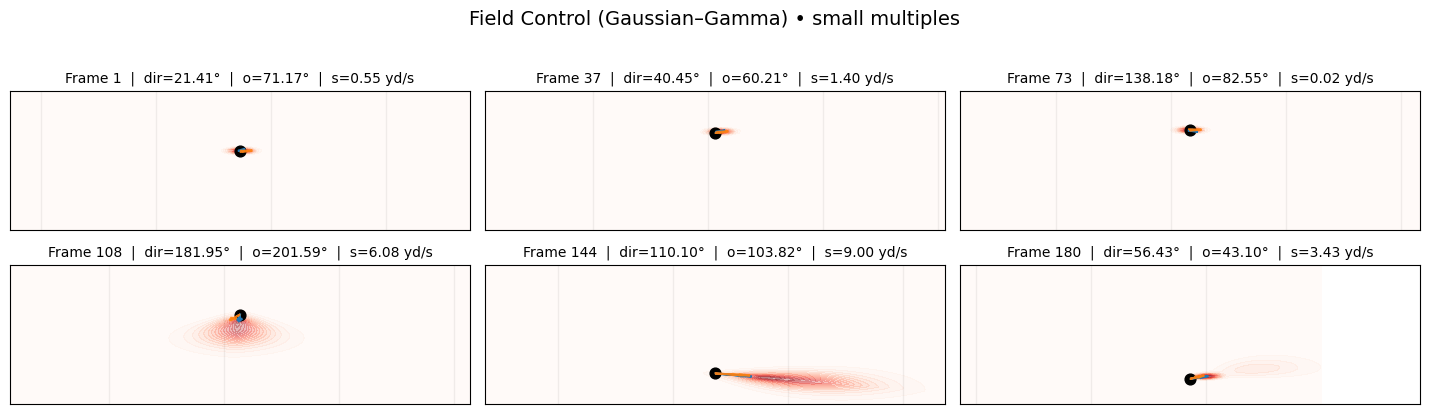

Frames plotted: [1, 37, 73, 108, 144, 180]


In [15]:
# df should be one player's rows with columns: frameId, x, y, dir, o, s, dist_from_football
fig, axes, frames = plot_field_control_small_multiples(single_player)
print("Frames plotted:", frames)  # e.g., [1, 30, 60, 90, 120, 150]


In [16]:
from __future__ import annotations

import math
from typing import Any, Dict, List, Optional, Sequence, Tuple, Union

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def diagnostic_multiples(
    df: pd.DataFrame,
    frame_id: int,
    player_id: Union[int, Sequence[int]],
    *,
    speed: float = 5.0,                 # Player evaluation speed (yd/s)

    # -------- Baseline knobs (applied to every panel unless overridden) ------
    # With the new class, keep this at 0.0 unless you *intentionally* want a bias.
    orientation_bias_deg: float = 0.0,
    gaussian_scale_factor: float = 0.7,
    alpha_gamma: float = 11.0,
    beta_min: float = 1.0,
    beta_max: float = 20.0,
    gamma_midpoint: float = 15.0,
    gamma_scale_factor: float = 0.8,
    max_forward_distance: float = 20.0,
    forward_decay_factor: float = 1.0,
    angle_limit_min: float = 15.0,
    angle_limit_max: float = 45.0,
    angle_decay_factor: float = 2.0,
    w_gaussian_min: float = 0.2,
    w_gaussian_max: float = 1.0,
    gaussian_midpoint: float = 4.0,
    gaussian_steepness: float = 2.0,

    # -------- Plot styling ---------------------------------------------------
    cmap: str = "Reds",
    alpha: float = 0.30,
    contour_levels: int = 18,
    zoom_x_range: float = 12.0,
    ylim: Optional[Tuple[float, float]] = (0.0, 53.0),
    grid_alpha: float = 0.20,
    cols: int = 4,

    # -------- Behavior / DF schema ------------------------------------------
    verbose: bool = False,
    x_col: str = "x",
    y_col: str = "y",
    dir_col: str = "dir",               # 0° up (+Y), 90° right (+X), clockwise increasing
    speed_col: str = "s",               # (not used; we evaluate at `speed`)
    dist_from_ball_col: str = "dist_from_football",
    name_col: str = "displayName",
) -> Tuple[plt.Figure, List[Dict[str, Any]]]:
    """
    Build a compact “cheat sheet” of small contour panels to visualize how each
    hyperparameter affects the Gaussian–Gamma influence field for one player.

    Each panel keeps the same player pose (position/heading) but overrides exactly
    one model knob, so you can see qualitative differences side-by-side.
    """
    # ---- Validate availability of the model --------------------------------
    try:
        PlayerInfluenceModel  # type: ignore[name-defined]
    except NameError as e:
        raise NameError(
            "PlayerInfluenceModel must be defined/imported before calling diagnostic_multiples()."
        ) from e

    # ---- Select the focal player row ---------------------------------------
    player_ids = np.atleast_1d(player_id)

    frame_rows = df[df["frameId"] == frame_id].copy()
    if name_col in frame_rows.columns:
        frame_rows = frame_rows[frame_rows[name_col].str.lower() != "football"]
    if frame_rows.empty:
        raise ValueError(f"No player rows found for frame_id={frame_id}.")

    sel = frame_rows[frame_rows["nflId"].isin(player_ids)]
    if sel.empty:
        sel = frame_rows  # fallback for demos

    row = sel.iloc[0]
    pos = (float(row[x_col]), float(row[y_col]))
    dir_deg = float(row[dir_col])
    dist = float(row[dist_from_ball_col]) if dist_from_ball_col in row and pd.notna(row[dist_from_ball_col]) else 0.0

    # ---- Helper to build a model with overrides ----------------------------
    def _build_model(**override: Any) -> PlayerInfluenceModel:
        model = PlayerInfluenceModel(
            orientation_bias_deg=orientation_bias_deg,  # defaults to 0.0 now
            gaussian_scale_factor=gaussian_scale_factor,
            alpha_gamma=alpha_gamma,
            beta_min=beta_min, beta_max=beta_max,
            gamma_midpoint=gamma_midpoint, gamma_scale_factor=gamma_scale_factor,
            max_forward_distance=max_forward_distance, forward_decay_factor=forward_decay_factor,
            angle_limit_min=angle_limit_min, angle_limit_max=angle_limit_max, angle_decay_factor=angle_decay_factor,
            w_gaussian_min=w_gaussian_min, w_gaussian_max=w_gaussian_max,
            gaussian_midpoint=gaussian_midpoint, gaussian_steepness=gaussian_steepness,
        )
        # Apply per-panel overrides
        for k, v in override.items():
            if not hasattr(model, k):
                raise AttributeError(f"Unknown model parameter '{k}'")
            setattr(model, k, v)
        return model

    # ---- Panels: (title, overrides) ----------------------------------------
    panels: List[Tuple[str, Dict[str, Any]]] = [
        ("Gaussian scale ↓", {"gaussian_scale_factor": max(0.2, gaussian_scale_factor * 0.6)}),
        ("Gaussian scale ↑", {"gaussian_scale_factor": gaussian_scale_factor * 1.4}),

        ("Gamma α ↓ (flatter)", {"alpha_gamma": max(2.0, alpha_gamma * 0.7)}),
        ("Gamma α ↑ (peakier)", {"alpha_gamma": alpha_gamma * 1.3}),

        ("Gamma reach ↓", {"max_forward_distance": max(6.0, max_forward_distance * 0.6)}),
        ("Gamma reach ↑", {"max_forward_distance": max_forward_distance * 1.4}),

        ("Gamma fade fast", {"forward_decay_factor": 0.6}),
        ("Gamma fade slow", {"forward_decay_factor": 2.0}),

        ("Cone narrow", {
            "angle_limit_min": min(max(angle_limit_min, 0.0) + 12.0, max(angle_limit_max - 5.0, angle_limit_min + 12.0)),
            "angle_limit_max": max(min(angle_limit_max, 85.0) - 12.0, angle_limit_min + 5.0),
        }),
        ("Cone wide", {
            "angle_limit_min": max(0.0, angle_limit_min - 12.0),
            "angle_limit_max": min(85.0, angle_limit_max + 12.0),
        }),

        ("More Gaussian", {"w_gaussian_min": min(0.8, w_gaussian_min + 0.2)}),
        ("More Gamma",    {"w_gaussian_min": max(0.0, w_gaussian_min - 0.2)}),
    ]

    # ---- Layout figure ------------------------------------------------------
    n = len(panels)
    cols_eff = max(1, int(cols))
    rows = math.ceil(n / cols_eff)
    fig, axes = plt.subplots(rows, cols_eff, figsize=(4.0 * cols_eff, 3.6 * rows))
    axes_arr = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else np.array([axes])

    panel_params: List[Dict[str, Any]] = []

    # ---- Render each panel --------------------------------------------------
    for ax, (title, overrides) in zip(axes_arr, panels):
        model = _build_model(**overrides)

        # Record the exact parameters used
        params = {
            "orientation_bias_deg": model.orientation_bias_deg,
            "gaussian_scale_factor": model.gaussian_scale_factor,
            "alpha_gamma": model.alpha_gamma,
            "beta_min": model.beta_min,
            "beta_max": model.beta_max,
            "gamma_midpoint": model.gamma_midpoint,
            "gamma_scale_factor": model.gamma_scale_factor,
            "max_forward_distance": model.max_forward_distance,
            "forward_decay_factor": model.forward_decay_factor,
            "angle_limit_min": model.angle_limit_min,
            "angle_limit_max": model.angle_limit_max,
            "angle_decay_factor": model.angle_decay_factor,
            "w_gaussian_min": model.w_gaussian_min,
            "w_gaussian_max": model.w_gaussian_max,
            "gaussian_midpoint": model.gaussian_midpoint,
            "gaussian_steepness": model.gaussian_steepness,
            "speed": speed,
        }
        panel_params.append({"title": title, "params": params})
        if verbose:
            print(f"[{title}] {params}")

        # Compute density for this panel / same player pose
        pos_off = model.compute_offset(pos, dir_deg, speed)
        Z = model.base_distribution(
            pos_xy=pos,
            pos_off_xy=pos_off,
            direction_deg=dir_deg,
            speed=speed,
            dist_from_ball=dist,
            alpha_gamma=model.alpha_gamma,
        )

        # Draw
        X, Y = model.grid.X, model.grid.Y
        ax.contourf(X, Y, Z, levels=contour_levels, cmap=cmap, alpha=alpha)
        ax.scatter(pos[0], pos[1], c="blue", edgecolor="black", s=45, zorder=5)

        # Arrow with the NEW mapping
        theta = model.theta_from_tracking(dir_deg, apply_bias=False)
        L = (speed / 11.3) * 4.0  # a touch smaller for readability
        ax.arrow(
            pos[0], pos[1],
            L * np.cos(theta), L * np.sin(theta),
            head_width=0.8, head_length=1.6,
            fc="black", ec="black", zorder=6
        )

        ax.set_title(title, fontsize=10)
        ax.set_xlim(pos[0] - zoom_x_range, pos[0] + zoom_x_range)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.grid(alpha=grid_alpha)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any leftover empty axes
    for i in range(len(panels), len(axes_arr)):
        axes_arr[i].axis("off")

    fig.suptitle(
        f"Influence Cheat Sheet • frame {frame_id} • player {player_id} • speed={speed:.2f} yd/s",
        fontsize=14
    )
    fig.tight_layout(rect=[0, 0.02, 1, 0.96])

    return fig, panel_params


Best params: {'orientation_bias_deg': 0.0, 'gaussian_scale_factor': 0.7, 'alpha_gamma': 11.0, 'beta_min': 1.0, 'beta_max': 20.0, 'gamma_midpoint': 15.0, 'gamma_scale_factor': 0.8, 'max_forward_distance': 20.0, 'forward_decay_factor': 2.0, 'angle_limit_min': 15.0, 'angle_limit_max': 45.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.2, 'w_gaussian_max': 1.0, 'gaussian_midpoint': 4.0, 'gaussian_steepness': 2.0, 'speed': 9}


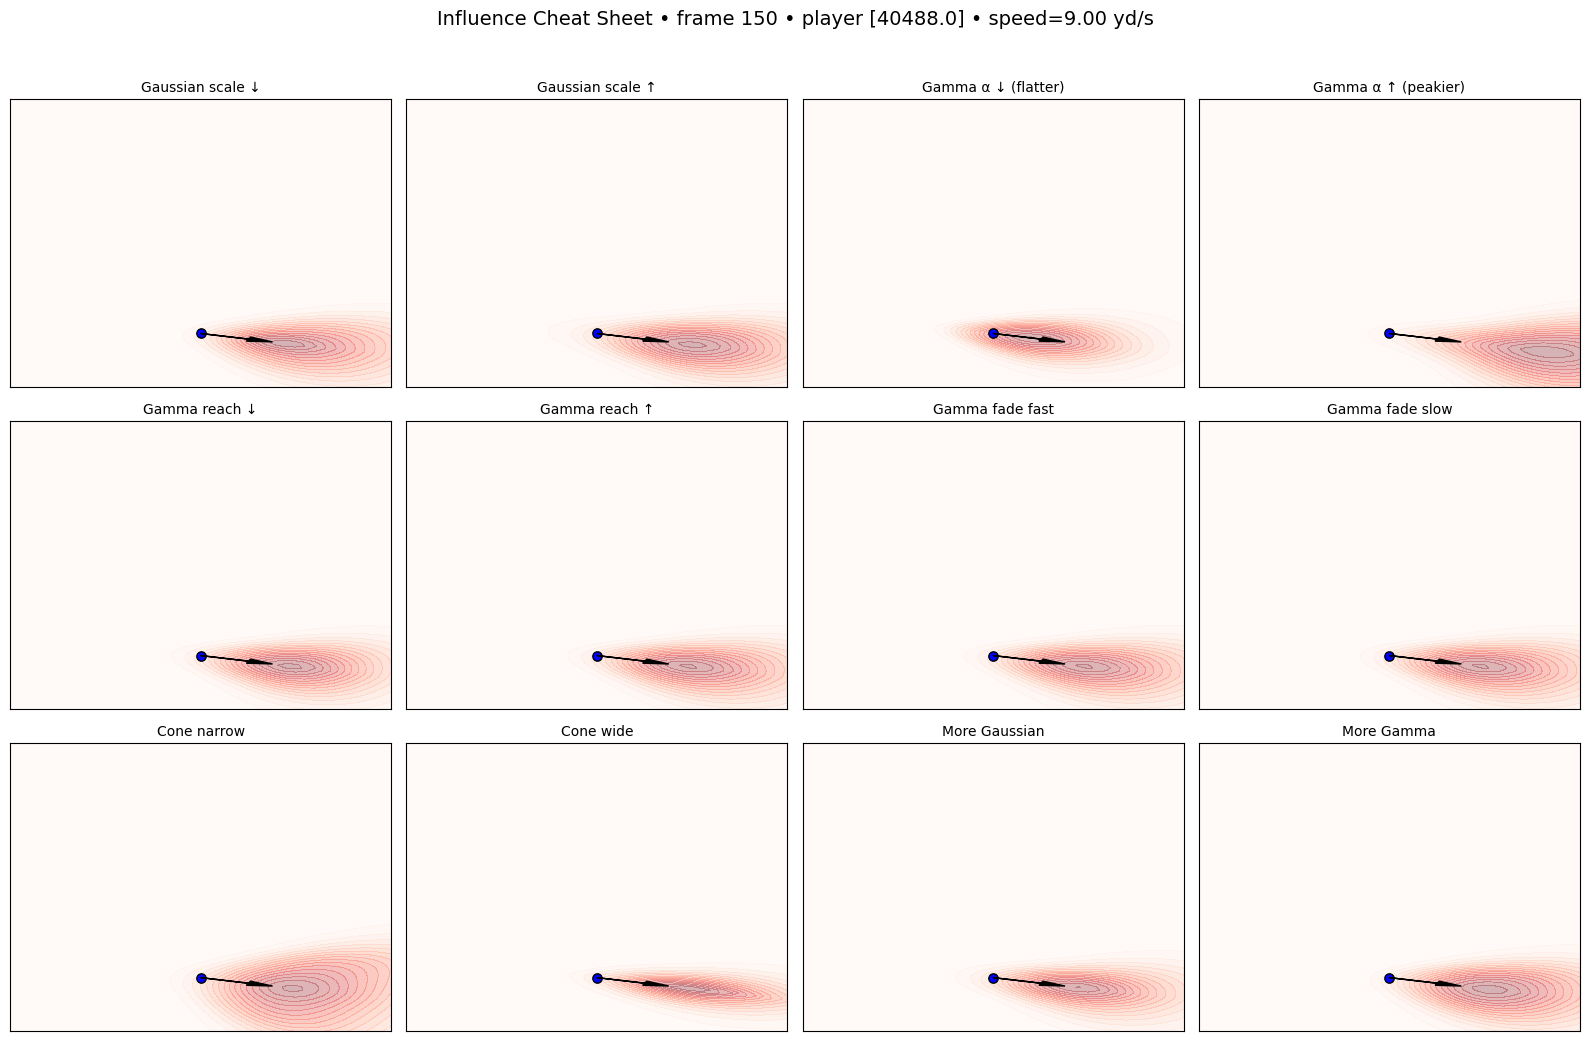

In [17]:
fig, params = diagnostic_multiples(df, frame_id=150, player_id=one_player, speed=9)

# Print the “winner” panel’s settings cleanly
best = next(p for p in params if p["title"] == "Gamma fade slow")  # for example
print("Best params:", best["params"])


In [18]:
def compute_player_densities_dataframe(
    df: pd.DataFrame,
    min_frame: int,
    max_frame: int,
    *,
    model_kwargs: Optional[dict] = None,   # e.g. {"orientation_bias_deg": 0.0, ...}
    alpha_gamma: float = 11.0,
    exclude_football: bool = True,
):
    """
    Compute Gaussian–Gamma densities for all players across [min_frame, max_frame]
    using PlayerInfluenceModel. Stores the orientation bias used so plotting
    can automatically match it later.

    Returns:
      - all_player_df: one row per (frameId, nflId) with the 2D 'density' grid
      - (X, Y): the model's grid (numpy arrays), for backward compatibility
    """
    if min_frame > max_frame:
        raise ValueError("min_frame must be less than or equal to max_frame.")

    # Build the model once with your chosen knobs
    model = PlayerInfluenceModel(**(model_kwargs or {}))
    X, Y = model.grid.X, model.grid.Y

    # Slice frames
    df_range = df[(df["frameId"] >= min_frame) & (df["frameId"] <= max_frame)].copy()
    if exclude_football and "displayName" in df_range.columns:
        df_range = df_range[df_range["displayName"].str.lower() != "football"]

    rows_out = []
    for frame_id in sorted(df_range["frameId"].unique()):
        frame_df = df_range[df_range["frameId"] == frame_id]
        if frame_df.empty:
            continue

        for _, r in frame_df.iterrows():
            try:
                pos = (float(r["x"]), float(r["y"]))
                dir_deg = float(r["dir"])
                spd = float(r["s"])
                dball = float(r.get("dist_from_football", 0.0))

                pos_off = model.compute_offset(pos, dir_deg, spd)
                Z = model.base_distribution(
                    pos_xy=pos,
                    pos_off_xy=pos_off,
                    direction_deg=dir_deg,
                    speed=spd,
                    dist_from_ball=dball,
                    alpha_gamma=alpha_gamma,
                )

                rows_out.append({
                    "frameId": frame_id,
                    "nflId": r["nflId"],
                    "displayName": r.get("displayName", None),
                    "jerseyNumber": r.get("jerseyNumber", None),
                    "x": pos[0],
                    "y": pos[1],
                    "speed": spd,
                    "direction": dir_deg,                    # raw tracking dir (0°=north, CW)
                    "is_off": r.get("is_off", None),
                    "dist_from_football": dball,
                    "orientation_bias_deg": model.orientation_bias_deg,  # store bias actually used
                    "density": Z,
                })
            except Exception as e:
                print(f"Error processing nflId={r.get('nflId')} in frame {frame_id}: {e}")

    all_player_df = pd.DataFrame(rows_out)
    return all_player_df, (X, Y)


In [19]:
def plot_player_densities_from_dataframe(
    player_df: pd.DataFrame,
    grid,                      # either (X, Y) tuple OR model.grid (Grid)
    frame_id: int,
    *,
    orientation_bias_deg: float = 0.0,   # fallback if a row doesn't store a bias
    contour_levels: int = 20,
    contour_alpha: float = 0.30,
    off_cmap: str = "Reds",
    on_cmap: str = "Blues",
    arrow_scale: float = 2.0,
    arrow_head_width: float = 0.375,
    arrow_head_length: float = 0.75,
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
    grid_alpha: float = 0.10,
    title: str = "Individual Player Influence",
    show: bool = True,
):
    """
    Plot precomputed densities. Arrows use the SAME angle mapping as the model:
        theta = radians(90 - direction_deg + row_bias)

    If a row lacks 'orientation_bias_deg', the function uses the fallback
    `orientation_bias_deg` provided here.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Accept either (X, Y) or a Grid object
    try:
        # Grid-like object with X, Y attributes
        X, Y = grid.X, grid.Y
    except AttributeError:
        # Tuple or list
        X, Y = grid

    _MAX_FIELD_X, _MAX_FIELD_Y = 120.0, 53.3

    f = player_df[player_df["frameId"] == frame_id].copy()
    if f.empty:
        print(f"Warning: no players found for frameId={frame_id}")
        return

    aspect = _MAX_FIELD_Y / _MAX_FIELD_X
    fig, ax = plt.subplots(figsize=(20, 20 * aspect))

    # Light yard lines
    for x in range(10, int(_MAX_FIELD_X), 10):
        ax.axvline(x, color="k", linestyle="-", alpha=0.05)

    def theta_from_tracking(deg: float, bias_deg: float) -> float:
        # Your convention → matplotlib radians (0 rad = +X, CCW)
        return np.deg2rad((90.0 - deg + bias_deg) % 360.0)

    for _, row in f.iterrows():
        if str(row.get("displayName", "")).lower() == "football":
            continue

        is_off = row.get("is_off", None)
        player_color = "blue" if is_off == 1 else "red"
        density_cmap = on_cmap if is_off == 1 else off_cmap

        # use per-row stored bias if present, otherwise the provided fallback
        row_bias = float(row.get("orientation_bias_deg", orientation_bias_deg))

        Z = row["density"]
        Z_masked = np.where(Z > 0.01, Z, np.nan)
        ax.contourf(X, Y, Z_masked, cmap=density_cmap, levels=contour_levels, alpha=contour_alpha)

        x0, y0 = float(row["x"]), float(row["y"])
        ax.scatter(x0, y0, color=player_color, s=200, edgecolor="black", zorder=5)

        jn = row.get("jerseyNumber", None)
        if jn is not None and not (isinstance(jn, float) and np.isnan(jn)):
            ax.text(x0, y0, f"{int(jn)}", fontsize=8, ha="center", color="white", zorder=6)

        name = row.get("displayName", None)
        if name:
            ax.text(x0, y0 - 1.5, str(name), fontsize=8, ha="center", color="black", zorder=6)

        dir_deg = row.get("direction", row.get("orientation", None))
        if dir_deg is not None:
            th = theta_from_tracking(float(dir_deg), row_bias)
            spd = float(row.get("speed", 0.0))
            L = arrow_scale * (1.0 + min(max(spd, 0.0), 11.3) / 11.3)  # modest speed scaling
            ax.arrow(
                x0, y0,
                L * np.cos(th), L * np.sin(th),
                head_width=arrow_head_width, head_length=arrow_head_length,
                fc="black", ec="black", zorder=4
            )

    ax.set_title(f"{title} — Frame {frame_id}")
    ax.set_xlabel("X (yards)")
    ax.set_ylabel("Y (yards)")
    ax.grid(alpha=grid_alpha)

    ax.set_xlim(*xlim) if xlim else ax.set_xlim(0, _MAX_FIELD_X)
    ax.set_ylim(*ylim) if ylim else ax.set_ylim(0, _MAX_FIELD_Y)

    if show:
        plt.show()

    return fig, ax


In [20]:
# 1) Compute densities (bias saved into each row)
all_player_df, grid = compute_player_densities_dataframe(
    df,
    min_frame=100,
    max_frame=150,
    model_kwargs=model_kwargs,
    alpha_gamma=11,
)




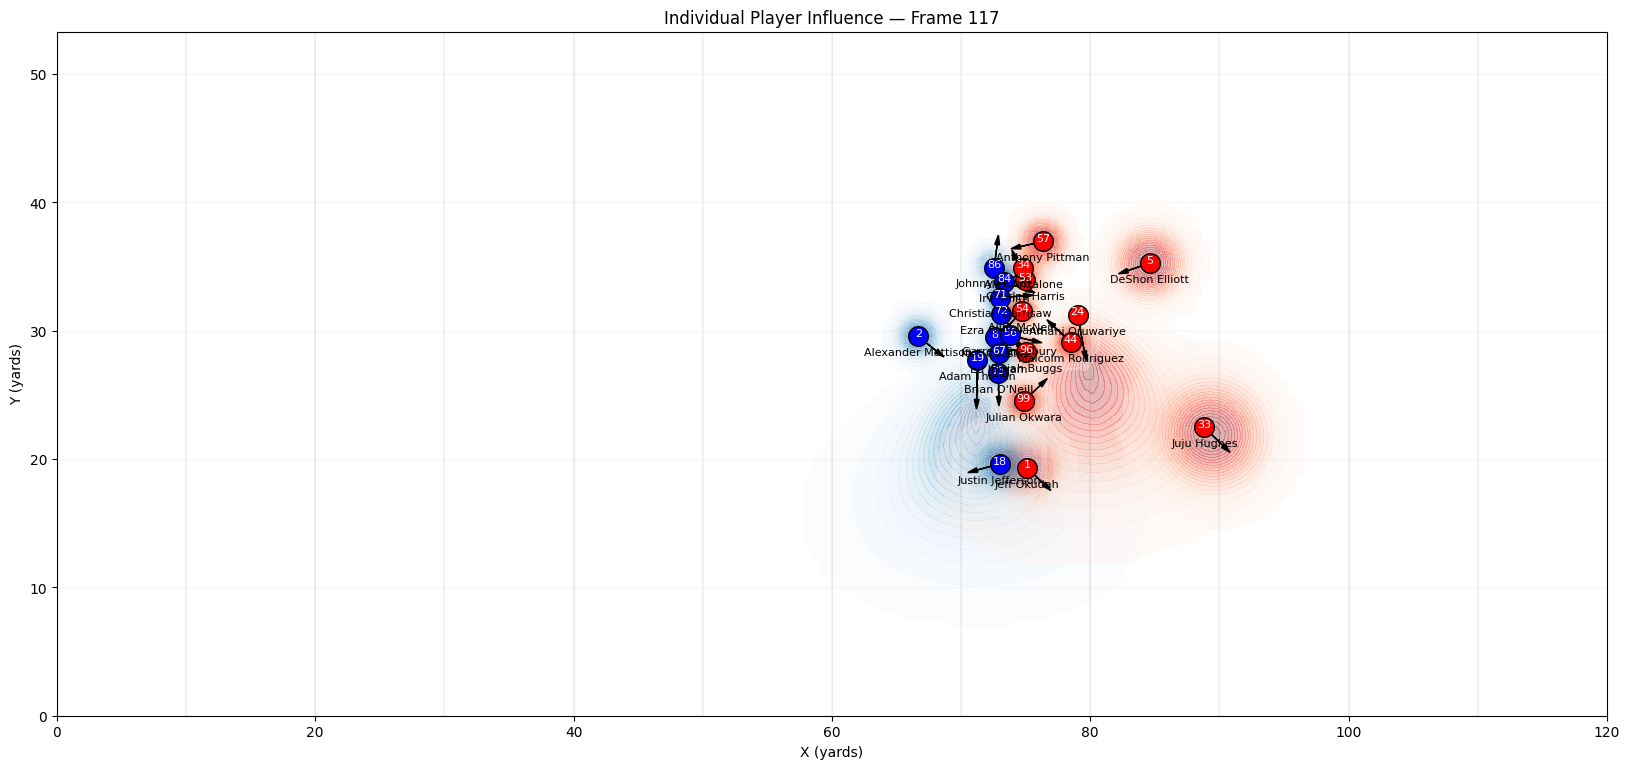

(<Figure size 2000x888.333 with 1 Axes>,
 <Axes: title={'center': 'Individual Player Influence — Frame 117'}, xlabel='X (yards)', ylabel='Y (yards)'>)

In [21]:
# 2) Plot a single frame, arrows aligned to the SAME bias used at compute time
plot_player_densities_from_dataframe(
    all_player_df,
    grid,
    frame_id=117,
    orientation_bias_deg=0.0,   # only used if a row is missing its stored bias
    title="Individual Player Influence",
    arrow_scale=1.8,            # tweak arrow size if you like
)

In [22]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow
from matplotlib import animation
from typing import Optional, Tuple


class AnimatePlayWithDensity:
    def __init__(
        self,
        play_df: pd.DataFrame,
        precomputed_df: pd.DataFrame,
        grid,                              # (X, Y) tuple OR a Grid object with .X/.Y
        plot_size_len: float = 16.0,
        *,
        # contours
        show_contours: bool = True,
        contour_levels: int = 20,
        contour_alpha: float = 0.30,
        off_cmap: str = "Reds",
        on_cmap: str  = "Blues",
        # arrows
        arrow_scale: float = 2.0,
        arrow_head_width: float = 0.50,     # was 0.375
        arrow_head_length: float = 1.00,    # was 0.75
        arrow_length_boost: float = 1.35,   # little extra length
        arrow_tail_width: float = 0.20,     # give the shaft some width
        # orientation fallback (used ONLY if a row lacks stored bias)
        orientation_bias_deg: float = 0.0,
        # view
        xlim: Optional[Tuple[float, float]] = None,
        ylim: Optional[Tuple[float, float]] = None,
        grid_alpha: float = 0.10,
        title: str = "Play Animation with Influence",
    ) -> None:
        """
        Animate a play using *precomputed* per‑player densities.

        Angles follow tracking convention: 0° = north (+Y), clockwise.
        Arrow heading: θ = radians(90 - deg + bias).
        """

        # constants
        self._MAX_FIELD_Y = 53.3
        self._MAX_FIELD_X = 120.0
        self._MAX_FIELD_PLAYERS = 22

        # data
        self._frame_data = play_df.copy()
        self._precomputed_df = precomputed_df.copy()

        # grid: accept either Grid object or (X, Y)
        try:
            self._X, self._Y = grid.X, grid.Y
        except AttributeError:
            self._X, self._Y = grid

        self._frames = sorted(self._frame_data.frameId.unique())

        # style / options
        self.show_contours = show_contours
        self.contour_levels = contour_levels
        self.contour_alpha = contour_alpha
        self.off_cmap = off_cmap
        self.on_cmap  = on_cmap

        self.arrow_scale = float(arrow_scale)
        self.arrow_head_width  = float(arrow_head_width)
        self.arrow_head_length = float(arrow_head_length)
        self.arrow_length_boost = float(arrow_length_boost)
        self.arrow_tail_width   = float(arrow_tail_width)

        self.orientation_bias_deg = float(orientation_bias_deg)
        self.xlim = xlim
        self.ylim = ylim
        self.grid_alpha = grid_alpha
        self._title = title

        # stream
        self._stream = self.data_stream()

        # fig/axes
        aspect = self._MAX_FIELD_Y / self._MAX_FIELD_X
        self._fig = plt.figure(figsize=(plot_size_len, plot_size_len * aspect))
        self._ax_field = plt.gca()

        # storage for artists
        self._scat_jersey_list = []
        self._scat_number_list = []
        self._scat_name_list   = []
        self._a_dir_list = []
        self._a_or_list  = []
        self._contours   = []

        # start animation
        self.ani = animation.FuncAnimation(
            self._fig, self.update, frames=len(self._frames),
            init_func=self.setup_plot, blit=False
        )
        plt.close()

    # ---------- angle helper (single source of truth) ----------
    @staticmethod
    def _theta_from_tracking(deg: float, bias_deg: float) -> float:
        """Convert tracking degrees (0°=north, clockwise) → matplotlib radians."""
        return np.deg2rad((90.0 - float(deg) + float(bias_deg)) % 360.0)

    # ---------- plumbing ----------
    @staticmethod
    def set_axis_plots(ax, max_x, max_y) -> None:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_xlim([0, max_x])
        ax.set_ylim([0, max_y])

    def data_stream(self):
        for frame in self._frames:
            yield self._frame_data[self._frame_data.frameId == frame]

    def setup_plot(self):
        # Field setup
        self.set_axis_plots(self._ax_field, self._MAX_FIELD_X, self._MAX_FIELD_Y)
        for idx in range(10, int(self._MAX_FIELD_X), 10):
            self._ax_field.axvline(idx, color='k', linestyle='-', alpha=0.05)

        # Initial scatters (single PathCollection each)
        self._scat_ball    = self._ax_field.scatter([], [], s=100, color='black', zorder=6)
        self._scat_offense = self._ax_field.scatter([], [], s=500, color='blue',  edgecolors='k', zorder=5)
        self._scat_defense = self._ax_field.scatter([], [], s=500, color='red',   edgecolors='k', zorder=5)

        # Pre-allocate text + arrows (so we can update in-place)
        for _ in range(self._MAX_FIELD_PLAYERS):
            self._scat_jersey_list.append(self._ax_field.text(0, 0, '', ha='center', va='center', c='white'))
            self._scat_number_list.append(self._ax_field.text(0, 0, '', ha='center', va='center', c='black'))
            self._scat_name_list.append(self._ax_field.text(0, 0, '', ha='center', va='center', c='black'))
            self._a_dir_list.append(self._ax_field.add_patch(Arrow(0, 0, 0, 0, color='k')))
            self._a_or_list.append(self._ax_field.add_patch(Arrow(0, 0, 0, 0, color='grey', width=2)))

        # Title & view
        self._ax_field.set_title(self._title)
        if self.xlim: self._ax_field.set_xlim(*self.xlim)
        if self.ylim: self._ax_field.set_ylim(*self.ylim)
        self._ax_field.grid(alpha=self.grid_alpha)

        return (self._scat_ball, self._scat_offense, self._scat_defense, *self._scat_jersey_list)

    def clear_contours_safe(self, contours_list):
        """Safely clear matplotlib contours across different versions."""
        for contour in contours_list:
            try:
                if hasattr(contour, 'collections'):
                    for collection in contour.collections:
                        collection.remove()
                elif hasattr(contour, 'remove'):
                    contour.remove()
                else:
                    for artist in contour:
                        if hasattr(artist, 'remove'):
                            artist.remove()
            except (TypeError, AttributeError, ValueError):
                continue
        contours_list.clear()

    # --- helper to robustly update a PathCollection (prevents “ghost” dots) ---
    @staticmethod
    def _set_offsets_safely(coll, xy: np.ndarray, size_each: float):
        """
        Replace offsets every frame and also shrink the collection when empty
        so stale points cannot linger.
        """
        if xy.size == 0:
            coll.set_offsets(np.empty((0, 2)))
            coll.set_sizes(np.array([]))
        else:
            coll.set_offsets(xy)
            # ensure the collection length matches the offsets
            coll.set_sizes(np.full(xy.shape[0], float(size_each)))

    def update(self, _frame_index):
        # grab next frame of positional data
        try:
            pos_df = next(self._stream)
        except StopIteration:
            self._stream = self.data_stream()
            pos_df = next(self._stream)

        frame_id = int(pos_df.frameId.iloc[0])

        # split
        offense_df = pos_df[pos_df.is_off == 1]
        defense_df = pos_df[pos_df.is_off == 0]
        ball_df    = pos_df[pos_df.team == 'football'] if 'team' in pos_df.columns \
                     else pos_df[pos_df.displayName.str.lower() == 'football']

        # update scatters (NO GHOSTS)
        to_xy = lambda d: np.column_stack((d["x"].to_numpy(float), d["y"].to_numpy(float))) if not d.empty else np.empty((0,2))
        self._set_offsets_safely(self._scat_offense, to_xy(offense_df), 500.0)
        self._set_offsets_safely(self._scat_defense, to_xy(defense_df), 500.0)
        self._set_offsets_safely(self._scat_ball,    to_xy(ball_df),    100.0)

        self._ax_field.set_title(f"{self._title} — Frame {frame_id}")

        # clear old contours
        self.clear_contours_safe(self._contours)

        # plot densities for this frame
        if self.show_contours:
            frame_density_df = self._precomputed_df[self._precomputed_df.frameId == frame_id]
            for _, prow in frame_density_df.iterrows():
                Z = prow.get('density', None)
                if Z is None:
                    continue
                cmap = self.on_cmap if prow.get('is_off', 0) == 1 else self.off_cmap
                Z_masked = np.where(Z > 0.01, Z, np.nan)
                cont = self._ax_field.contourf(self._X, self._Y, Z_masked,
                                               cmap=cmap, levels=self.contour_levels, alpha=self.contour_alpha)
                self._contours.append(cont)

        # update per-player labels + arrows
        labeled = pos_df[pos_df.jerseyNumber.notnull()].reset_index(drop=True)
        for idx in range(min(len(labeled), self._MAX_FIELD_PLAYERS)):
            row = labeled.iloc[idx]
            x0, y0 = float(row.x), float(row.y)

            # jersey/number/name
            self._scat_jersey_list[idx].set_position((x0, y0))
            self._scat_jersey_list[idx].set_text(row.position if 'position' in row else '')
            self._scat_number_list[idx].set_position((x0, y0 + 1.5))
            try:
                self._scat_number_list[idx].set_text(int(row.jerseyNumber))
            except Exception:
                self._scat_number_list[idx].set_text('')
            self._scat_name_list[idx].set_position((x0, y0 - 1.5))
            name = row.displayName.split()[-1] if isinstance(row.displayName, str) else ''
            self._scat_name_list[idx].set_text(name)

            # Resolve heading (direction) for this player
            theta_rad = None
            match = self._precomputed_df[
                (self._precomputed_df.frameId == frame_id) & (self._precomputed_df.nflId == row.nflId)
            ]
            if not match.empty:
                theta_rad = match.iloc[0].get('theta_rad', None)

            if theta_rad is None:
                row_bias = self.orientation_bias_deg
                if not match.empty and ('orientation_bias_deg' in match.columns):
                    try:
                        row_bias = float(match.iloc[0].get('orientation_bias_deg', row_bias))
                    except Exception:
                        pass
                theta_rad = self._theta_from_tracking(float(row.dir), row_bias)

            # arrow length (modest speed scaling + boost)
            spd = float(row.s) if 's' in row else 0.0
            L = self.arrow_length_boost * self.arrow_scale * (1.0 + min(max(spd, 0.0), 11.3) / 11.3)

            # replace "direction" (black) arrow
            self._a_dir_list[idx].remove()
            self._a_dir_list[idx] = self._ax_field.add_patch(
                Arrow(x0, y0, L*np.cos(theta_rad), L*np.sin(theta_rad),
                      color='k', width=self.arrow_tail_width,
                      lw=0,  # Arrow patch ignores lw; width controls shaft
                      alpha=1.0, zorder=7)
            )

            # replace "orientation" (grey) arrow — optional
            self._a_or_list[idx].remove()
            orient_theta = None
            if ('o' in row) and (row.o == row.o):  # pd.notna(row.o) without importing pd here
                orient_theta = self._theta_from_tracking(float(row.o), row_bias)
                self._a_or_list[idx] = self._ax_field.add_patch(
                    Arrow(x0, y0, (L*0.6)*np.cos(orient_theta), (L*0.6)*np.sin(orient_theta),
                          color='grey', width=self.arrow_tail_width*1.2, alpha=0.95, zorder=6)
                )
            else:
                self._a_or_list[idx] = self._ax_field.add_patch(Arrow(0, 0, 0, 0, color='grey', width=0))

        # Hide any unused artists (including removing leftover arrows)
        for idx in range(len(labeled), self._MAX_FIELD_PLAYERS):
            self._scat_jersey_list[idx].set_text('')
            self._scat_number_list[idx].set_text('')
            self._scat_name_list[idx].set_text('')
            self._a_dir_list[idx].remove()
            self._a_or_list[idx].remove()

        return (self._scat_ball, self._scat_offense, self._scat_defense,
                *self._scat_jersey_list, *self._scat_number_list, *self._scat_name_list,
                *self._a_dir_list, *self._a_or_list)



In [23]:
# 1) Compute per-player densities for a frame range
all_player_df, grid = compute_player_densities_dataframe(
    df=df,                # full tracking data for the play
    min_frame=1,
    max_frame=max(df['frameId'])-1,
    model_kwargs=model_kwargs,
    alpha_gamma=11,
)

# 2) Animate the play with precomputed densities
animator = AnimatePlayWithDensity(
    play_df=df,         # your play’s positional data (all frames)
    precomputed_df=all_player_df,
    grid=grid,
    plot_size_len=16,
    orientation_bias_deg=0.0,    # fallback if per-row bias is missing
    arrow_scale=1.4,             # smaller arrows
    title="Pitch Control + Player Influence"
)

# 3) Display the animation inline (in Colab / Jupyter)

# OR save to a file:
animator.ani.save("play_influence.mp4", fps=10, dpi=150)


# Team Level Field Control

In [24]:
def compute_player_densities_with_pitch_control(
    model,
    df,
    frame_id,
    *,
    grid=None,                          # (X, Y) tuple; if None, uses model.grid or builds default
    smooth_sigma=2.0,                   # gaussian smoothing for influence maps
    pitch_k=25.0,                       # sigmoid steepness for pitch control
    neutral_band=(0.45, 0.55),          # mask band for "neutral" areas
    use_cached_density=True,            # use 'density' column if available
    force_recompute=False,              # <-- NEW: recompute even if cache exists
    cache_back_to_df=False              # if computed, store density back onto df for reuse
):
    """
    Compute offense/defense influence and pitch control for a single frame.

    IMPORTANT: If your cached 'density' grids were computed with an older angle
    convention, set `force_recompute=True` so we regenerate with the updated class.
    """

    # --- grid setup ----------------------------------------------------------
    if grid is not None:
        X, Y = grid
    elif hasattr(model, "grid") and model.grid is not None:
        try:
            X, Y = model.grid.X, model.grid.Y   # new class Grid
        except AttributeError:
            X, Y = model.grid                    # fallback for (X, Y) tuple-like
    else:
        x_vals = np.linspace(0.0, 120.0, 200)
        y_vals = np.linspace(0.0, 53.3, 100)
        X, Y = np.meshgrid(x_vals, y_vals)

    x_vals = X[0, :]
    y_vals = Y[:, 0]

    # --- helpers -------------------------------------------------------------
    def _sigmoid(z, k):
        return 1.0 / (1.0 + np.exp(-k * z))

    def _safe_norm(A):
        mx = A.max()
        return A / mx if mx > 0 else A

    # --- frame slice ---------------------------------------------------------
    frame_df = df[df["frameId"] == frame_id]
    if frame_df.empty:
        raise ValueError(f"No data found for frame {frame_id}.")

    # Exclude ball / invalid rows up front
    frame_df = frame_df.loc[
        (frame_df["displayName"].str.lower() != "football") &
        (~frame_df["is_off"].isna())
    ].copy()

    # --- density acquisition -------------------------------------------------
    densities = None
    can_batch = hasattr(model, "compute_densities")
    have_cache = ("density" in frame_df.columns) and frame_df["density"].notna().all()

    if use_cached_density and have_cache and not force_recompute:
        # Use cached densities as-is
        densities = np.stack(frame_df["density"].to_numpy(), axis=0)
    else:
        # Recompute with the UPDATED class logic
        dens_list = []

        if can_batch and hasattr(model, "compute_influence"):
            # If you have a batch compute, you can swap to it here.
            # For clarity and correctness, we do per-row using the new recipe.
            pass

        for _, r in frame_df.iterrows():
            # Required fields
            pos = (float(r["x"]), float(r["y"]))
            dir_deg = float(r["dir"] if "dir" in r else r["direction"])
            spd = float(r["s"] if "s" in r else r["speed"])
            dball = float(r.get("dist_from_football", 0.0))

            # With the NEW class: place gamma anchor behind the player,
            # then mix Gaussian + Gamma using the new angle mapping (no hidden bias).
            pos_off = model.compute_offset(pos, dir_deg, spd)
            Z = model.base_distribution(
                pos_xy=pos,
                pos_off_xy=pos_off,
                direction_deg=dir_deg,
                speed=spd,
                dist_from_ball=dball,
            )
            dens_list.append(Z)

        densities = np.stack(dens_list, axis=0)
        if cache_back_to_df:
            frame_df.loc[:, "density"] = dens_list  # store updated grids

    # --- threshold tiny values to remove speckle -----------------------------
    densities = np.where(densities < 1e-3, 0.0, densities)

    # --- split & accumulate offense/defense ---------------------------------
    is_off_mask = frame_df["is_off"].to_numpy().astype(bool)
    inf_offense = densities[is_off_mask].sum(axis=0) if is_off_mask.any() else np.zeros_like(X)
    inf_defense = densities[~is_off_mask].sum(axis=0) if (~is_off_mask).any() else np.zeros_like(X)

    # --- normalize → smooth --------------------------------------------------
    inf_offense = _safe_norm(inf_offense)
    inf_defense = _safe_norm(inf_defense)

    if smooth_sigma and smooth_sigma > 0:
        from scipy.ndimage import gaussian_filter
        inf_offense = gaussian_filter(inf_offense, sigma=smooth_sigma)
        inf_defense = gaussian_filter(inf_defense, sigma=smooth_sigma)

    # --- pitch control (defense→1.0) ----------------------------------------
    pitch_control = _sigmoid(inf_defense - inf_offense, k=pitch_k)

    # mask near-50/50 band
    lo, hi = neutral_band
    mask = (pitch_control >= lo) & (pitch_control <= hi)
    pitch_control_masked = np.where(mask, np.nan, pitch_control)

    # --- per-player summary table -------------------------------------------
    sum_density = densities.reshape(densities.shape[0], -1).sum(axis=1)
    player_df = frame_df.assign(
        frameId=frame_id,
        sum_density=sum_density,
    ).copy()

    # Consistent columns if present
    keep_cols = [
        "frameId", "nflId", "displayName", "jerseyNumber",
        "x", "y", "dir", "direction", "s", "speed",
        "is_off", "density", "sum_density"
    ]
    player_df = player_df[[c for c in keep_cols if c in player_df.columns]]

    # --- grid -> DataFrames --------------------------------------------------
    offense_influence_df = pd.DataFrame(inf_offense, index=y_vals, columns=x_vals)
    defense_influence_df = pd.DataFrame(inf_defense, index=y_vals, columns=x_vals)
    pitch_control_df   = pd.DataFrame(pitch_control_masked, index=y_vals, columns=x_vals)

    return player_df, offense_influence_df, defense_influence_df, pitch_control_df


#Team Level Field Control

In [25]:
def compute_player_densities_with_pitch_control(
    model,
    df,
    frame_id,
    *,
    grid=None,
    smooth_sigma=2.0,
    pitch_k=25.0,
    neutral_band=(0.45, 0.55),
    use_cached_density=True,
    force_recompute=False,
    cache_back_to_df=False,
    # NEW: make the heading source explicit and add a safe flip
    heading_col: str = "dir",          # use "dir" unless you truly store raw heading in "direction"
    invert_heading: bool = False,      # set True only if you confirm a 180° flip in your data
):
    import numpy as np
    import pandas as pd
    from scipy.ndimage import gaussian_filter

    # --- grid ---------------------------------------------------------------
    if grid is not None:
        X, Y = grid
    elif hasattr(model, "grid") and model.grid is not None:
        try:
            X, Y = model.grid.X, model.grid.Y
        except AttributeError:
            X, Y = model.grid
    else:
        x_vals = np.linspace(0.0, 120.0, 200)
        y_vals = np.linspace(0.0, 53.3, 100)
        X, Y = np.meshgrid(x_vals, y_vals)
    x_vals = X[0, :]; y_vals = Y[:, 0]

    def _sigmoid(z, k): return 1.0 / (1.0 + np.exp(-k * z))
    def _safe_norm(A):  mx = A.max(); return A / mx if mx > 0 else A

    # --- frame slice --------------------------------------------------------
    frame_df = df[df["frameId"] == frame_id]
    if frame_df.empty:
        raise ValueError(f"No data found for frame {frame_id}.")
    frame_df = frame_df.loc[
        (frame_df["displayName"].str.lower() != "football") & (~frame_df["is_off"].isna())
    ].copy()

    # --- densities ----------------------------------------------------------
    densities = None
    have_cache = ("density" in frame_df.columns) and frame_df["density"].notna().all()
    if use_cached_density and have_cache and not force_recompute:
        densities = np.stack(frame_df["density"].to_numpy(), axis=0)
    else:
        dens_list = []
        for _, r in frame_df.iterrows():
            x0, y0 = float(r["x"]), float(r["y"])
            pos = (x0, y0)

            # pick heading column consistently
            if heading_col in r and pd.notna(r[heading_col]):
                dir_deg = float(r[heading_col])
            elif "direction" in r and pd.notna(r["direction"]):
                dir_deg = float(r["direction"])
            else:
                raise KeyError(f"Row missing heading column '{heading_col}'/'direction'.")

            if invert_heading:
                dir_deg = (dir_deg + 180.0) % 360.0  # safe flip if needed

            spd   = float(r["s"] if "s" in r else r["speed"])
            dball = float(r.get("dist_from_football", 0.0))

            pos_off = model.compute_offset(pos, dir_deg, spd)
            Z = model.base_distribution(
                pos_xy=pos,
                pos_off_xy=pos_off,
                direction_deg=dir_deg,
                speed=spd,
                dist_from_ball=dball,
            )
            dens_list.append(Z)

        densities = np.stack(dens_list, axis=0)
        if cache_back_to_df:
            frame_df.loc[:, "density"] = dens_list

    densities = np.where(densities < 1e-3, 0.0, densities)

    is_off_mask = frame_df["is_off"].to_numpy().astype(bool)
    inf_offense = densities[is_off_mask].sum(axis=0) if is_off_mask.any() else np.zeros_like(X)
    inf_defense = densities[~is_off_mask].sum(axis=0) if (~is_off_mask).any() else np.zeros_like(X)

    inf_offense = _safe_norm(inf_offense)
    inf_defense = _safe_norm(inf_defense)
    if smooth_sigma and smooth_sigma > 0:
        inf_offense = gaussian_filter(inf_offense, sigma=smooth_sigma)
        inf_defense = gaussian_filter(inf_defense, sigma=smooth_sigma)

    pitch_control = _sigmoid(inf_defense - inf_offense, k=pitch_k)
    lo, hi = neutral_band
    pitch_control = np.where((pitch_control >= lo) & (pitch_control <= hi), np.nan, pitch_control)

    sum_density = densities.reshape(densities.shape[0], -1).sum(axis=1)
    player_df = frame_df.assign(frameId=frame_id, sum_density=sum_density).copy()

    keep_cols = [
        "frameId","nflId","displayName","jerseyNumber",
        "x","y",heading_col,"dir","direction","s","speed",
        "is_off","density","sum_density"
    ]
    player_df = player_df[[c for c in keep_cols if c in player_df.columns]]

    offense_influence_df = pd.DataFrame(inf_offense, index=y_vals, columns=x_vals)
    defense_influence_df = pd.DataFrame(inf_defense, index=y_vals, columns=x_vals)
    pitch_control_df     = pd.DataFrame(pitch_control, index=y_vals, columns=x_vals)
    return player_df, offense_influence_df, defense_influence_df, pitch_control_df


In [26]:
def visualize_pitch_control_with_players(
    pitch_control_df: pd.DataFrame,
    player_df: pd.DataFrame,
    frame_id: int,
    *,
    heading_col: str = "dir",      # "dir" in your data; can switch to "direction" if needed
    invert_heading: bool = False,  # set True only if you’ve confirmed a 180° flip upstream
    arrow_scale: float = 5.0,
    constant_arrow: bool = False,
    xlim=(60, 110),
    ylim=(5, 45),
):
    """
    Visualize pitch control for one frame + player dots, numbers, names, and arrows.
    Angles follow the class mapping: theta = radians(90 - deg).
    """


    def theta_from_tracking(deg: float) -> float:
        return np.deg2rad((90.0 - float(deg)) % 360.0)

    # --- figure and pitch-control surface -----------------------------------
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title(f"Team Field Control — Frame {frame_id}")

    cs = ax.contourf(
        pitch_control_df.columns, pitch_control_df.index, pitch_control_df.values,
        cmap="coolwarm", levels=20, alpha=0.8
    )
    fig.colorbar(cs, ax=ax, label="Field Control (defense → 1.0)")

    # --- slice once, then iterate as tuples (scalars!) -----------------------
    f = player_df[player_df["frameId"] == frame_id].copy()

    # Make sure the columns we read exist (won’t raise ambiguous Series truth errors)
    has_speed = "s" in f.columns or "speed" in f.columns
    has_heading = (heading_col in f.columns) or ("direction" in f.columns)

    for row in f.itertuples(index=False):
        # Access by attribute (scalars)
        x0 = float(getattr(row, "x"))
        y0 = float(getattr(row, "y"))
        is_off_val = getattr(row, "is_off", 0)
        try:
            is_off_bool = bool(int(is_off_val))
        except Exception:
            is_off_bool = False

        color = "blue" if is_off_bool else "red"
        ax.scatter(x0, y0, color=color, edgecolor="black", s=120, zorder=5)

        jn = getattr(row, "jerseyNumber", None)
        if jn is not None and not (isinstance(jn, float) and np.isnan(jn)):
            ax.text(x0, y0 + 1.0, f"{int(jn)}", fontsize=9, ha="center", color="black", zorder=6)

        name = getattr(row, "displayName", "")
        if isinstance(name, str) and name:
            ax.text(x0, y0 - 1.4, name, fontsize=8, ha="center", color="black", zorder=6)

        # --- arrow: use the SAME heading convention as the class -------------
        if has_heading:
            deg = getattr(row, heading_col, None)
            if deg is None or (isinstance(deg, float) and np.isnan(deg)):
                deg = getattr(row, "direction", None)

            if deg is not None and not (isinstance(deg, float) and np.isnan(deg)):
                deg = float(deg)
                if invert_heading:
                    deg = (deg + 180.0) % 360.0

                th = theta_from_tracking(deg)
                spd = getattr(row, "s", None)
                if spd is None:
                    spd = getattr(row, "speed", 0.0)
                try:
                    spd = float(spd)
                except Exception:
                    spd = 0.0

                L = (arrow_scale if constant_arrow else arrow_scale * (spd / 11.3))
                ax.arrow(
                    x0, y0,
                    L * np.cos(th), L * np.sin(th),
                    head_width=0.375, head_length=0.75, fc="black", ec="black", zorder=7
                )

    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.set_xlabel("X (yards)"); ax.set_ylabel("Y (yards)")
    ax.grid(alpha=0.4)
    plt.show()



In [27]:
def heading_alignment_check(df, pid, frame_col="frameId", id_col="nflId", x="x", y="y", heading="dir"):
    g = df[df[id_col]==pid].sort_values(frame_col).copy()
    g["dx"] = g[x].diff(); g["dy"] = g[y].diff()
    # cos(angle between heading vector and displacement)
    th = np.deg2rad((90.0 - g[heading]) % 360.0)
    hx, hy = np.cos(th), np.sin(th)
    num = hx*g["dx"] + hy*g["dy"]
    den = np.sqrt(hx**2+hy**2) * np.sqrt(g["dx"]**2 + g["dy"]**2)
    print("mean cos ≈", np.nanmean(num/den))  # should be > 0 ; ~1 is perfect, ~-1 means 180° flip


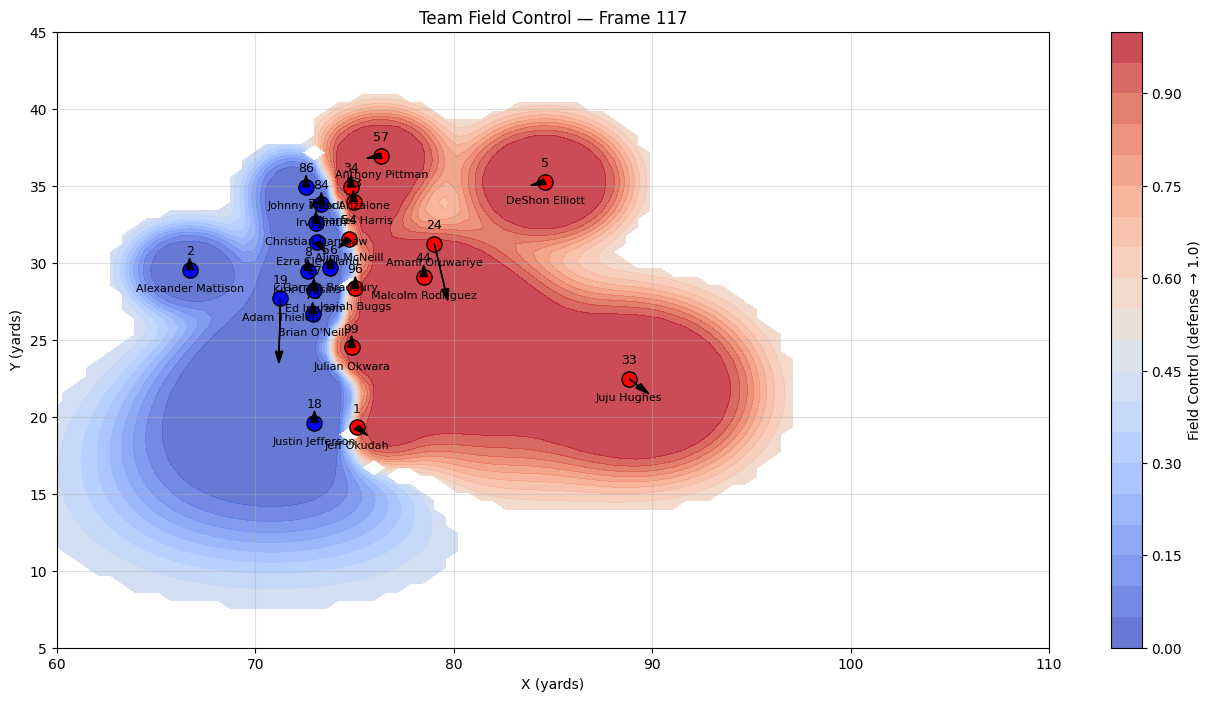

In [28]:
player_df2, off_df, def_df, pc_df = compute_player_densities_with_pitch_control(
    model=PlayerInfluenceModel(orientation_bias_deg=0.0),
    df=df, frame_id=117, use_cached_density=False, force_recompute=True,
    heading_col="dir", invert_heading=False
)

visualize_pitch_control_with_players(
    pc_df, player_df2, frame_id=117,
    heading_col="dir", invert_heading=False
)


# Now we will animate team level influence

Now that we can produce frame level analysis of team control, let's see if we can animate similar to our player level densities to see how a play evolves over time.

In [29]:
from typing import Iterable, Optional, Tuple, Dict, List, Union
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter

def compute_player_densities_with_pitch_control_multi(
    model,                         # PlayerInfluenceModel instance (required if recomputing)
    df: pd.DataFrame,
    *,
    # which frames?
    frames: Optional[Iterable[int]] = None,   # explicit set/list of frames to compute
    min_frame: Optional[int] = None,          # if frames=None, build from [min_frame, max_frame]
    max_frame: Optional[int] = None,
    n_even: Optional[int] = None,             # if set, pick n evenly-spaced frames in [min,max]
    # grid/model
    grid: Optional[Tuple[np.ndarray, np.ndarray]] = None,  # (X, Y); if None, use model.grid or default
    # influence → pitch-control knobs
    smooth_sigma: float = 2.0,
    pitch_k: float = 25.0,
    neutral_band: Tuple[float, float] = (0.45, 0.55),
    # density caching/recompute
    use_cached_density: bool = True,
    force_recompute: bool = False,
    cache_back_to_df: bool = False,
    # heading handling (to match your updated class)
    heading_col: str = "dir",
    invert_heading: bool = False,
    # misc
    exclude_football: bool = True,
    verbose: bool = False,
):
    """
    Compute player influence (Gaussian–Gamma) and pitch control for MANY frames.

    Returns
    -------
    players_all : pd.DataFrame
        One row per (frameId, player) with 'density' (np.ndarray), 'sum_density', etc.
    offense_by_frame : Dict[int, pd.DataFrame]
        Offense influence grid per frame (rows=y, cols=x).
    defense_by_frame : Dict[int, pd.DataFrame]
        Defense influence grid per frame (rows=y, cols=x).
    pitch_by_frame : Dict[int, pd.DataFrame]
        Pitch control per frame (rows=y, cols=x), with neutral band masked to NaN.
    grid_out : Tuple[np.ndarray, np.ndarray]
        The (X, Y) grid used for all frames.
    frames_used : List[int]
        Exact list of frameIds that were computed (in order).
    """

    # ------------------------ grid setup ------------------------------------
    if grid is not None:
        X, Y = grid
    elif hasattr(model, "grid") and getattr(model, "grid", None) is not None:
        try:
            X, Y = model.grid.X, model.grid.Y
        except AttributeError:
            X, Y = model.grid
    else:
        x_vals = np.linspace(0.0, 120.0, 200)
        y_vals = np.linspace(0.0, 53.3, 100)
        X, Y = np.meshgrid(x_vals, y_vals)

    x_vals = X[0, :]
    y_vals = Y[:, 0]
    grid_out = (X, Y)

    # ------------------------ frame list ------------------------------------
    if frames is not None:
        frames_used = sorted(set(int(f) for f in frames))
    else:
        fmin = int(min_frame if min_frame is not None else df["frameId"].min())
        fmax = int(max_frame if max_frame is not None else df["frameId"].max())
        if n_even and n_even > 0:
            # pick n_even evenly spaced frame ids that exist in df
            present = np.sort(df["frameId"].unique())
            targets = np.linspace(fmin, fmax, n_even)
            frames_used = []
            for t in targets:
                nearest = int(present[np.argmin(np.abs(present - t))])
                if not frames_used or frames_used[-1] != nearest:
                    frames_used.append(nearest)
        else:
            frames_used = list(range(fmin, fmax + 1))

    # ------------------------ helpers ---------------------------------------
    def _sigmoid(z, k): return 1.0 / (1.0 + np.exp(-k * z))
    def _safe_norm(A):
        mx = A.max()
        return A / mx if mx > 0 else A

    # outputs
    rows_out: List[dict] = []
    offense_by_frame: Dict[int, pd.DataFrame] = {}
    defense_by_frame: Dict[int, pd.DataFrame] = {}
    pitch_by_frame: Dict[int, pd.DataFrame] = {}

    # ------------------------ main loop -------------------------------------
    for fid in frames_used:
        frame_df = df[df["frameId"] == fid].copy()
        if frame_df.empty:
            if verbose:
                print(f"[compute_multi] frame {fid}: no rows; skipping")
            continue

        if exclude_football and "displayName" in frame_df.columns:
            frame_df = frame_df[frame_df["displayName"].str.lower() != "football"]
        if "is_off" in frame_df.columns:
            frame_df = frame_df[frame_df["is_off"].notna()]
        frame_df = frame_df.reset_index(drop=True)
        if frame_df.empty:
            if verbose:
                print(f"[compute_multi] frame {fid}: only football/NaN is_off rows; skipping")
            continue

        # ---- densities for this frame
        densities = None
        have_cache = ("density" in frame_df.columns) and frame_df["density"].notna().all()

        if use_cached_density and have_cache and not force_recompute:
            # trust the cached per-row arrays
            densities = np.stack(frame_df["density"].to_numpy(), axis=0)
        else:
            if model is None:
                raise ValueError(
                    f"Recompute requested but no `model` provided (frame={fid}). "
                    "Pass a PlayerInfluenceModel or set use_cached_density=True."
                )

            dens_list = []
            for _, r in frame_df.iterrows():
                x0, y0 = float(r["x"]), float(r["y"])
                pos = (x0, y0)

                # pick heading column consistently (dir preferred, else direction)
                if heading_col in r and pd.notna(r[heading_col]):
                    dir_deg = float(r[heading_col])
                elif "direction" in r and pd.notna(r["direction"]):
                    dir_deg = float(r["direction"])
                else:
                    # default to 0 if truly missing; could also raise
                    dir_deg = 0.0

                if invert_heading:
                    dir_deg = (dir_deg + 180.0) % 360.0

                spd = float(r["s"] if "s" in r else r.get("speed", 0.0))
                dball = float(r.get("dist_from_football", 0.0))

                pos_off = model.compute_offset(pos, dir_deg, spd)
                Z = model.base_distribution(
                    pos_xy=pos,
                    pos_off_xy=pos_off,
                    direction_deg=dir_deg,
                    speed=spd,
                    dist_from_ball=dball,
                )
                dens_list.append(Z)

            densities = np.stack(dens_list, axis=0)
            if cache_back_to_df:
                frame_df.loc[:, "density"] = dens_list

        # clean speckle
        densities = np.where(densities < 1e-3, 0.0, densities)

        # offense/defense split
        is_off_mask = frame_df["is_off"].to_numpy().astype(bool) if "is_off" in frame_df.columns else np.zeros(len(frame_df), bool)
        inf_off = densities[is_off_mask].sum(axis=0) if is_off_mask.any() else np.zeros_like(X)
        inf_def = densities[~is_off_mask].sum(axis=0) if (~is_off_mask).any() else np.zeros_like(X)

        # normalize + smooth
        inf_off = _safe_norm(inf_off)
        inf_def = _safe_norm(inf_def)
        if smooth_sigma and smooth_sigma > 0:
            inf_off = gaussian_filter(inf_off, sigma=smooth_sigma)
            inf_def = gaussian_filter(inf_def, sigma=smooth_sigma)

        # pitch control (defense→1.0)
        pc = _sigmoid(inf_def - inf_off, k=pitch_k)
        lo, hi = neutral_band
        pc_masked = np.where((pc >= lo) & (pc <= hi), np.nan, pc)

        # per-player summary
        sum_density = densities.reshape(densities.shape[0], -1).sum(axis=1)
        frame_rows = frame_df.assign(frameId=fid, sum_density=sum_density).copy()

        # unify common column names used by downstream visualizations
        if "s" in frame_rows.columns and "speed" not in frame_rows.columns:
            frame_rows = frame_rows.rename(columns={"s": "speed"})
        if heading_col in frame_rows.columns and "direction" not in frame_rows.columns:
            frame_rows = frame_rows.rename(columns={heading_col: "direction"})

        rows_out.append(frame_rows)

        # stash grids as DataFrames (y as index, x as columns)
        offense_by_frame[fid] = pd.DataFrame(inf_off, index=y_vals, columns=x_vals)
        defense_by_frame[fid] = pd.DataFrame(inf_def, index=y_vals, columns=x_vals)
        pitch_by_frame[fid]   = pd.DataFrame(pc_masked, index=y_vals, columns=x_vals)

        if verbose and (fid == frames_used[0] or fid == frames_used[-1] or fid % 10 == 0):
            print(f"[compute_multi] frame {fid}: players={len(frame_rows)}")

    # concat all player rows across frames
    players_all = pd.concat(rows_out, ignore_index=True) if rows_out else pd.DataFrame()

    return players_all, offense_by_frame, defense_by_frame, pitch_by_frame, grid_out, frames_used


In [30]:
max(df['frameId'])

180

In [31]:
# Build/choose your model once
model = PlayerInfluenceModel(orientation_bias_deg=0.0)

# Compute for 6 evenly spaced frames across your play (perfect for animation)
players_all, off_by_f, def_by_f, pc_by_f, grid, frames_used = compute_player_densities_with_pitch_control_multi(
    model=model,
    df=df,                             # full play rows
    min_frame = 1,
    max_frame = max(df['frameId']),
    heading_col="dir",
    invert_heading=False,
    smooth_sigma=2.0,
    pitch_k=25.0,
    neutral_band=(0.45, 0.55),
    use_cached_density=False,          # recompute from model
    force_recompute=True,              # alias; OK to set
    cache_back_to_df=False,
    verbose=True,
)

print("Frames used:", frames_used)


[compute_multi] frame 1: players=22
[compute_multi] frame 10: players=22
[compute_multi] frame 20: players=22
[compute_multi] frame 30: players=22
[compute_multi] frame 40: players=22
[compute_multi] frame 50: players=22
[compute_multi] frame 60: players=22
[compute_multi] frame 70: players=22
[compute_multi] frame 80: players=22
[compute_multi] frame 90: players=22
[compute_multi] frame 100: players=22
[compute_multi] frame 110: players=22
[compute_multi] frame 120: players=22
[compute_multi] frame 130: players=22
[compute_multi] frame 140: players=22
[compute_multi] frame 150: players=22
[compute_multi] frame 160: players=22
[compute_multi] frame 170: players=22
[compute_multi] frame 180: players=22
Frames used: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 

In [32]:


def animate_pitch_control_with_players(
    *,
    player_df: pd.DataFrame,
    pc_by_frame: dict,                  # {frameId: pitch_control_df}
    frames: list,                       # ordered list of frameIds to animate
    heading_col: str = "direction",     # compute_* functions store heading here
    arrow_scale: float = 5.0,
    constant_arrow: bool = False,
    xlim=(60, 110),
    ylim=(5, 45),
    cmap="coolwarm",
    levels: int = 20,
    surface_alpha: float = 0.8,
    figsize=(16, 8),
    show_colorbar: bool = True,
):
    """Animate team pitch control + player dots/numbers/names/arrows."""

    def theta_from_tracking(deg: float) -> float:
        # 0° = north/up (+Y), clockwise → matplotlib (0 rad = +X, CCW)
        return np.deg2rad((90.0 - float(deg)) % 360.0)

    # ---------- figure & static scaffolding ----------
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.set_xlabel("X (yards)"); ax.set_ylabel("Y (yards)")
    ax.grid(alpha=0.4)
    for xv in range(10, 120, 10):
        ax.axvline(xv, color="k", lw=1, alpha=0.06)

    f0 = frames[0]
    Z0 = pc_by_frame[f0].values
    X = pc_by_frame[f0].columns.values
    Y = pc_by_frame[f0].index.values

    # draw first surface and capture the artists explicitly
    cs0 = ax.contourf(X, Y, Z0, cmap=cmap, levels=levels, alpha=surface_alpha)
    contour_artists = list(getattr(cs0, "collections", [])) or (cs0 if hasattr(cs0, "__iter__") else [])
    cbar = None
    if show_colorbar:
        cbar = fig.colorbar(cs0, ax=ax, label="Field Control (defense → 1.0)")

    title = ax.set_title(f"Team Field Control — Frame {f0}")

    # holders we’ll refresh each frame
    scatters, texts_num, texts_name, arrows = [], [], [], []

    def _clear_artists(artists):
        # Safely remove any list of artists
        for a in list(artists):
            try:
                a.remove()
            except Exception:
                pass
        artists.clear()

    def _draw_players(frame_id: int):
        _clear_artists(scatters)
        _clear_artists(texts_num)
        _clear_artists(texts_name)
        _clear_artists(arrows)

        f = player_df[player_df["frameId"] == frame_id]
        for row in f.itertuples(index=False):
            x0 = float(getattr(row, "x"))
            y0 = float(getattr(row, "y"))
            is_off_val = getattr(row, "is_off", 0)
            try:
                is_off_bool = bool(int(is_off_val))
            except Exception:
                is_off_bool = False
            color = "blue" if is_off_bool else "red"

            sc = ax.scatter(x0, y0, color=color, edgecolor="black", s=120, zorder=5)
            scatters.append(sc)

            jn = getattr(row, "jerseyNumber", None)
            if jn is not None and not (isinstance(jn, float) and np.isnan(jn)):
                tnum = ax.text(x0, y0 + 1.0, f"{int(jn)}", fontsize=9, ha="center", color="black", zorder=6)
                texts_num.append(tnum)

            name = getattr(row, "displayName", "")
            if isinstance(name, str) and name:
                tname = ax.text(x0, y0 - 1.4, name, fontsize=8, ha="center", color="black", zorder=6)
                texts_name.append(tname)

            # heading
            deg = getattr(row, heading_col, getattr(row, "dir", None))
            if deg is not None and not (isinstance(deg, float) and np.isnan(deg)):
                th = theta_from_tracking(float(deg))
                spd = getattr(row, "speed", getattr(row, "s", 0.0))
                try:
                    spd = float(spd)
                except Exception:
                    spd = 0.0
                L = (arrow_scale if constant_arrow else arrow_scale * (spd / 11.3))
                ar = ax.arrow(
                    x0, y0, L*np.cos(th), L*np.sin(th),
                    head_width=0.375, head_length=0.75, fc="black", ec="black", zorder=7
                )
                arrows.append(ar)

    _draw_players(f0)

    def _update(i):
        fid = frames[i]
        title.set_text(f"Team Field Control — Frame {fid}")

        # remove previous contour artists robustly
        _clear_artists(contour_artists)

        # draw new surface and refresh the stored artist list
        cs = ax.contourf(X, Y, pc_by_frame[fid].values, cmap=cmap, levels=levels, alpha=surface_alpha)
        contour_artists[:] = list(getattr(cs, "collections", [])) or (cs if hasattr(cs, "__iter__") else [])

        if cbar is not None:
            try:
                cbar.update_normal(cs)
            except Exception:
                # fallback: replace colorbar mappable
                cbar.mappable = cs
                cbar.draw_all()

        _draw_players(fid)
        # return all artists for blit=False (harmless) or completeness
        return contour_artists + scatters + texts_num + texts_name + arrows + [title]

    ani = animation.FuncAnimation(fig, _update, frames=len(frames), interval=120, blit=False)
    plt.close(fig)
    return ani



In [33]:
ani = animate_pitch_control_with_players(
    player_df=players_all,
    pc_by_frame=pc_by_f,
    frames=frames_used,
    heading_col="direction",  # or "dir" if that’s what your table has
    arrow_scale=5.0,
    xlim=(60,110), ylim=(5,45),
)


ani.save("team_field_control.mp4", fps=5, dpi=100)